## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

The images for camera calibration are stored in the folder called camera_cal.

In [422]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [423]:
images

['camera_cal/calibration1.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration16.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration9.jpg']

In [424]:
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## 2. Apply a distortion correction to raw images.

In [425]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # undist = np.copy(img)  # Delete this line
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst,mtx,dist


OpenCV functions were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (calibration2.jpg).

The distortion matrix **(mtx)** is used to un-distort the calibration image. It can be seen in the undistorted image that the processing worked, as observed in the lack of a curvature in the top edge of the chessboard.

undistorting sample image:  camera_cal/calibration2.jpg


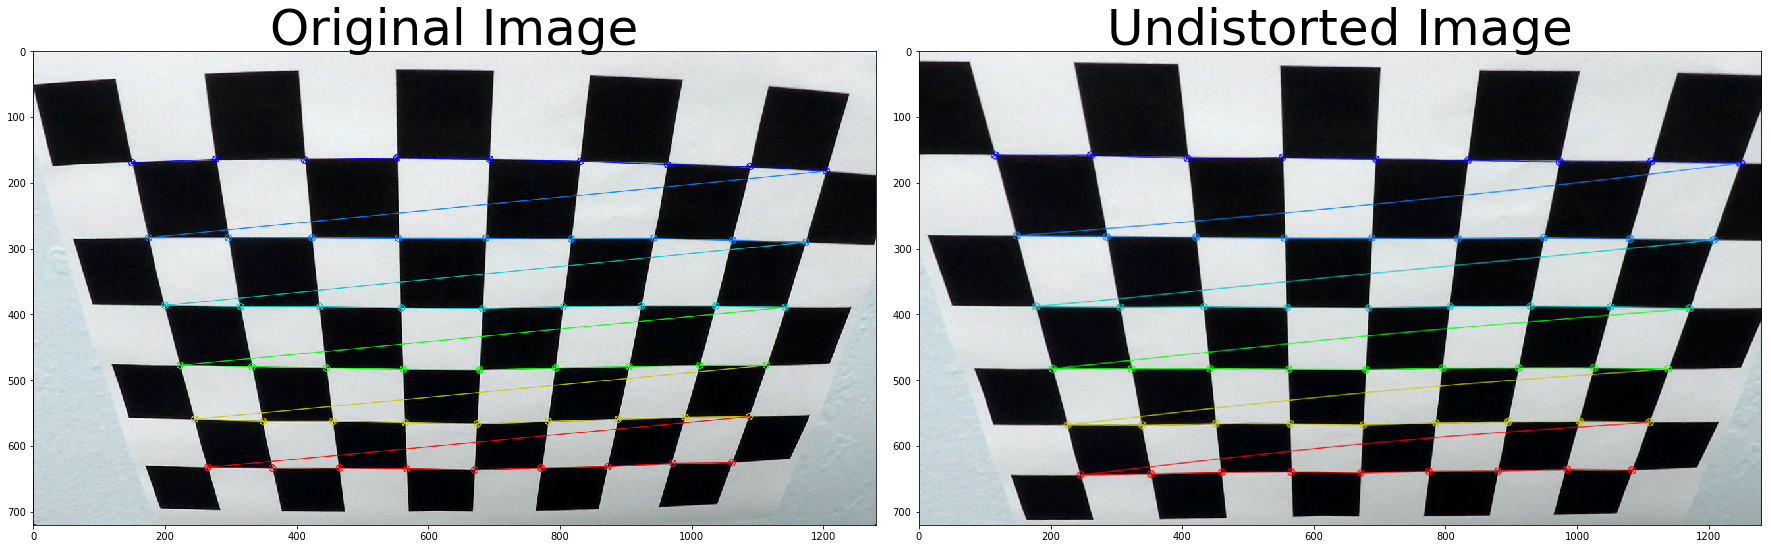

In [7]:
img = cv2.imread(images[11])
print('undistorting sample image: ',images[11])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

# If found, add object points, image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    img2 = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

undistorted,mtx,dist = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/distortion_correction_output.jpg',figsize=(1,1))

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

Described below is how I used color transforms, gradients or other methods to create a thresholded binary image. Provided is an example of a binary image result.

In [8]:
test_images = glob.glob('test_images/test*.jpg')
line_images = glob.glob('test_images/straight_lines*.jpg')
test_images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

In [555]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = cv2.GaussianBlur(img,(5,5),0)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    v_channel = hls[:,:,2]    
    
    # Explore gradients in other colors spaces / color channels to see what might work better
    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary,color_binary    

**Provided below are examples of binary image result.**

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

The code for my perspective transform includes a function called warper(), which appears in lines 1 through 8 in the file example.py (examples/example.py) . The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. I chose the hardcode the source and destination points in the following manner:



In [556]:
def warper(img, 
            src=np.float32([(580,460),
                   (702,460), 
                   (1124,720),
                   (201,720) 
                   ]) , 
           dst = np.float32([(450,0),
                  (1200-450,0),
                  (1200-450,720),
                  (450,720)
                  ])
          ):

#     src=np.float32([(580,460),
#            (702,460), 
#            (1124,720),
#            (201,720) 
#            ]) 
#     dst = np.float32([(320,0),
#            (960,0),
#            (960,720),
#            (320,720)
#            ]) 

    # Compute and apply perpective transform
    # Return transform matrix
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    
    return warped,M,Minv


def undistort(img,mtx,dist):
    undistorted=cv2.undistort(img,mtx,dist,None,mtx)
    return undistorted

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


## 5. Detect lane pixels and fit to find the lane boundary.

In [557]:
def sliding_window(image=None,mtx=mtx,dist=dist, nwindows = 10,margin = 90,minpix = 50):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
#     binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    binary_warped,stack_binary= pipeline(warped)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    

    # # Find the peak of the left and right halves of the histogram
    # # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,return_M,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    

In [558]:
def get_curvature(ploty,lefty,righty,leftx,rightx,
                  xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    #     lefty/righty is the actual pixel sample's y-value
    #     leftx/rightx is the actual pixel sample's x-value

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #     print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad,right_curverad


In [559]:
def extract_curvature(left_line=None,right_line=None):
    l_radius_of_curvature,r_radius_of_curvature = get_curvature(ploty=left_line.ploty, \
                                                 lefty=left_line.ally, \
                                                 righty=right_line.ally,\
                                                 leftx=left_line.allx,\
                                                 rightx=right_line.allx)
    return l_radius_of_curvature,r_radius_of_curvature


def extract_roc(left_line=None,right_line=None):
    l_radius_of_curvature=get_curvature(left_line)
    return l_radius_of_curvature,r_radius_of_curvature


In [560]:
def update_lanes(image=None,mtx=mtx,dist=dist
                 , nwindows = 9,margin = 80
                 ,minpix = 50, left_fit_previous=None
                 ,right_fit_previous=None):
    undistorted = undistort(image, mtx,dist)
    img_size=undistorted.shape
    w=img_size[1]
    h=img_size[0]
    
    warped,perspective_M,return_M =  warper(undistorted)    
#     binary_warped,stack_binary = pipeline(warped)
    binary_warped,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))
    #         pipeline_binary,stack_binary= pipeline(warped, s_thresh=(210, 255),sx_thresh=(230,255))    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     margin = 100
#     margin=60
    left_lane_inds = ((nonzerox > (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + left_fit_previous[2] - margin)) & (nonzerox < (left_fit_previous[0]*(nonzeroy**2) + left_fit_previous[1]*nonzeroy + left_fit_previous[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + right_fit_previous[2] - margin)) & (nonzerox < (right_fit_previous[0]*(nonzeroy**2) + right_fit_previous[1]*nonzeroy + right_fit_previous[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     return out_img,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    return result,left_fitx,right_fitx,ploty,leftx,lefty,rightx,righty,left_fit,right_fit
    


In [569]:
# Define a class to receive the characteristics of each line detection
def return_line(orig_image,warped_image,left_fitx,right_fitx,ploty,return_M, left_curverad,right_curverad,tint=(0,255,0)):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Calculate the offset and position     
    c_offset,c_pos=extract_offset(image=warped_image,left_fitx=left_fitx,right_fitx=right_fitx)

    # Draw the lane onto the warped blank image
    color_warp=cv2.fillPoly(warp_zero, np.int_([pts]), tint)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, return_M, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    
    
    new_img = np.copy(result)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature(L): ' + '{:04.2f}'.format(left_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    text = 'Radius of Curvature(R): ' + '{:04.2f}'.format(right_curverad) + 'm'
    cv2.putText(new_img, text, (40,120), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
#     image,left_fitx=None,right_fitx=None,xm_per_pix = 3.7/700)
    text = 'Vehicle is ' + '{:01.2f}'.format(c_offset) +'m ' + c_pos
    cv2.putText(new_img, text, (40,170), font, 1.5, (0,255,155), 2, cv2.LINE_AA)
    return new_img


import numpy as np
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.fitx = None
        self.ploty = None
        self.warped_img = None
        
class Lane():
    def __init__(self):
        self.left_line = Line()
        self.right_line = Line()
        self.out_image = None
        self.inverse_M = None
        self.mtx = None
        self.image=None
        self.detected=False
        self.n_fail=0
    def get_curvature(self):
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ally, \
                                                     righty=self.right_line.ally,\
                                                     leftx=self.left_line.allx,\
                                                     rightx=self.right_line.allx)

    def set_lanelines(self,tint=(0,255,0)):
        self.out_image= return_line(orig_image=self.image,warped_image=self.warped_img, \
                                  left_fitx=self.left_line.fitx,right_fitx=self.right_line.fitx, \
                                  ploty=self.left_line.ploty,return_M=self.inverse_M, left_curverad=self.left_line.radius_of_curvature, \
                                  right_curverad=self.right_line.radius_of_curvature,tint=tint)
        
    def update(self,image):
#         self.image=image

        self.warped_img,self.left_line, self.right_line = update_lines(image=image, \
                                          left_line=self.left_line, \
                                          right_line=self.right_line)
        r_curvature = self.right_line.radius_of_curvature
        l_curvature = self.left_line.radius_of_curvature
        
# update self.left_line.radius_of_curvature,self.right_line.radius_of_curvature
        self.get_curvature()
        
    #         check threshold of curvature difference
#         if((self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
#            self.right_line.radius_of_curvature <0.5):
#         update if left and right curves are within 50%
#         use weighted average
        left_curve_change = abs(self.left_line.radius_of_curvature-l_curvature)/l_curvature
        right_curve_change = abs(self.right_line.radius_of_curvature-r_curvature)/r_curvature
    
        self.left_line.best_fit=0.7*self.left_line.current_fit +0.3*self.left_line.best_fit
        self.image=image
        
        
        if(right_curve_change<0.5):
            self.right_line.best_fit=0.7*self.right_line.current_fit + 0.3*self.right_line.best_fit
        else:
            pass
            self.detected=True
        self.set_lanelines(tint=(0,255,0))
#         else:
# #             self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
# #             left_line=self.left_line, \
# #             right_line=self.right_line)
# #             self.get_curvature()
# #             self.out_image=image
# #             self.out_image=image
#             self.left_line.best_fit=self.left_line.best_fit
#             self.right_line.best_fit=self.right_line.best_fit
#             self.image=image
#             self.detected=False
#             self.set_lanelines()

#             pass
    
# START COMMENT    
# #         check threshold of curvature difference
#         if((self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
#            self.right_line.radius_of_curvature <0.5):
# #         update if left and right curves are within 50%
# #         use weighted average
#             self.left_line.best_fit=0.7*self.left_line.current_fit +0.3*self.left_line.best_fit
#             self.right_line.best_fit=0.7*self.right_line.current_fit + 0.3*self.right_line.best_fit
#             self.image=image
#             self.detected=True
#             self.set_lanelines()
#         else:
# #             self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
# #             left_line=self.left_line, \
# #             right_line=self.right_line)
# #             self.get_curvature()
# #             self.out_image=image
# #             self.out_image=image
#             self.left_line.best_fit=self.left_line.best_fit
#             self.right_line.best_fit=self.right_line.best_fit
#             self.image=image
#             self.detected=False
#             self.set_lanelines()

#             pass
# END COMMENT
        
    def bootstrap_lane_lines(self,image):
#         self.image=image

#         self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
#                                                      lefty=self.left_line.ally, \
#                                                      righty=self.right_line.ally,\
#                                                      leftx=self.left_line.allx,\
#                                                      rightx=self.right_line.allx)

#     def set_lanelines(self):
#         self.out_image= return_line(orig_image=self.image,warped_image=self.warped_img, \
#                                   left_fitx=self.left_line.fitx,right_fitx=self.right_line.fitx, \
#                                   ploty=self.left_line.ploty,return_M=self.inverse_M, left_curverad=self.left_line.radius_of_curvature, \
#                                   right_curverad=self.right_line.radius_of_curvature)

#         self.right_line.best_fit = right_best_fit
#         self.left_line.best_fit = left_best_fit
# #     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#         self.right_line.best_fit = right_best_fit
#         self.left_line.best_fit = left_best_fit
#         print(left_bestfit,'LEFT')
#         print(self.left_line.best_fit,'AFTER LEFT')
        self.left_line.fitx = self.left_line.best_fit[0]*(self.left_line.ploty**2) + self.left_line.best_fit[1]*self.left_line.ploty + self.left_line.best_fit[2]
        self.right_line.fitx = self.right_line.best_fit[0]*(self.right_line.ploty**2) + self.right_line.best_fit[1]*self.right_line.ploty + self.right_line.best_fit[2]
        
        self.left_line.radius_of_curvature,self.right_line.radius_of_curvature = get_curvature(ploty=self.left_line.ploty, \
                                                     lefty=self.left_line.ploty, \
                                                     righty=self.right_line.ploty,\
                                                     leftx=self.left_line.fitx,\
                                                     rightx=self.right_line.fitx)
        
#         self.get_curvature()
        
        self.image=image
        
#         self.right_line.best_fit = right_best_fit
#         self.left_line.best_fit = left_best_fit

        self.set_lanelines(tint=(255,0,0))

    def sliding_window(self,image):
        self.image=image
        self.warped_img,self.inverse_M,self.left_line.fitx,self.right_line.fitx,\
            self.left_line.ploty,self.left_line.allx,self.left_line.ally,\
            self.right_line.allx,self.right_line.ally,self.left_line.current_fit,\
            self.right_line.current_fit = sliding_window(image)
        self.get_curvature()
        self.right_line.ploty=self.left_line.ploty
#         self.set_lanelines()
        
        if (self.right_line.best_fit is None) :
            self.right_line.best_fit=self.right_line.current_fit

        if (self.left_line.best_fit is None) :
            self.left_line.best_fit=self.left_line.current_fit
            
#         check threshold of curvature difference
        if(abs(self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.right_line.radius_of_curvature <0.5):
#       DIFFERENCE IS ACCEPTABLE (<50%)
            self.left_line.best_fit=self.left_line.current_fit
            self.right_line.best_fit=self.right_line.current_fit
            self.detected=True
            print('SLIDING:CURVATURE accepted')
#             self.set_lanelines()

        else:
#             self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
#             left_line=self.left_line, \
#             right_line=self.right_line)
#             self.get_curvature()
#             self.left_line.best_fit=self.left_line.best_fit
#             self.right_line.best_fit=self.right_line.best_fit
        
#             self.out_image=image
#             self.out_image=image
            print('SLIDING:CURVATURE TOO DIFFERENT')
            self.detected=True
        
        self.image=image
        self.set_lanelines()
#         self.set_lanelines
        
def update_to_best_fit(self,image):
#         self.image=image
        self.out_image,self.left_line, self.right_line = update_lines(image=image, \
                                          left_line=self.left_line, \
                                          right_line=self.right_line)
        self.get_curvature()
#         self.set_lanelines()
        
#         check threshold of curvature difference
        if((self.left_line.radius_of_curvature-self.right_line.radius_of_curvature)/ \
           self.right_line.radius_of_curvature <0.5):
            self.left_line.best_fit=self.left_line.current_fit
            self.right_line.best_fit=self.right_line.current_fit
            self.image=image
            self.detected=True
        else:
            self.out_image,self.left_line, self.right_line = update_lines(image=self.image, \
            left_line=self.left_line, \
            right_line=self.right_line)
            self.get_curvature()

        self.set_lanelines()

       

In [570]:
def update_lines(image=None,left_line=None,right_line=None):
    out_img,left_line.fitx,right_line.fitx, \
    left_line.ploty,left_line.allx, \
    left_line.ally,right_line.allx, \
    right_line.ally,left_line.current_fit, \
    right_line.current_fit = update_lanes( image, \
                                          left_fit_previous=left_line.best_fit, \
                                          right_fit_previous=right_line.best_fit) 
#                                           left_fit_previous=left_line.current_fit, \
#                                           right_fit_previous=right_line.current_fit) 
    return out_img,left_line, right_line

In [571]:
temp_lane = Lane()
temp_lane.sliding_window(mpimg.imread(line_images[1]))
# plt.figure()
# plt.imshow(temp_lane.out_image)
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)
# temp_lane.update(mpimg.imread(test_images[1]))
# print(temp_lane.left_line.radius_of_curvature, temp_lane.right_line.radius_of_curvature)


SLIDING:CURVATURE TOO DIFFERENT


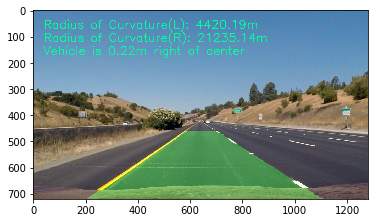

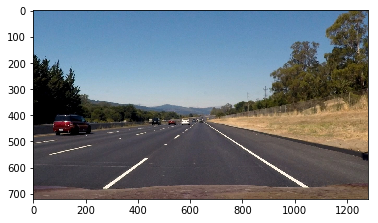

In [572]:
temp_lane.update(mpimg.imread(line_images[0]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(line_images[1]))

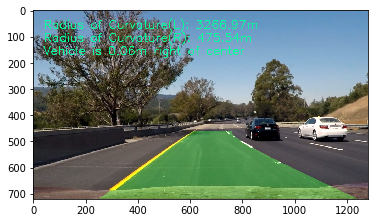

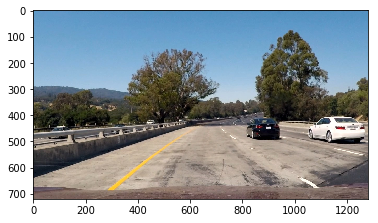

In [573]:
temp_lane.update(mpimg.imread(test_images[5]))
plt.imshow(temp_lane.out_image)
plt.figure()
plt.imshow(mpimg.imread(test_images[0]))

## Test on Videos

In [142]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [143]:
lane_container=Lane()

In [574]:
lane_container=Lane()
# lane_container.sliding_window(image)
lane_container.sliding_window(mpimg.imread(line_images[0]))
def process_image(image):
    try:
        if(lane_container.detected==True):
            lane_container.update(image)
            print('complete')
        else:
            lane_container.sliding_window(image)
            print('window-notdetected')
            
    except:
        try:
            lane_container.sliding_window(image) 
            print('window')
        except:
            print('fail')
            pass
        else:
            
            print('fail')
            pass
        
    l_fit_x_int = lane_container.left_line.fitx[image.shape[0]-1]
    r_fit_x_int = lane_container.right_line.fitx[image.shape[0]-1]
    print(l_fit_x_int, r_fit_x_int, r_fit_x_int - l_fit_x_int)
#     print('LFIT',lane_container.left_line.best_fit)
    if ((r_fit_x_int - l_fit_x_int)<450.0 ) and ((r_fit_x_int - l_fit_x_int)>250.0):
        
#         if(abs(R-R0)/R0>0.5)
        if((lane_container.left_line.radius_of_curvature-lane_container.right_line.radius_of_curvature)/ \
           lane_container.right_line.radius_of_curvature <0.5):
#        abs(R-R0)/R0  # R = current radius of curvature
#             print(lane_container.left_line.best_fit)
#             print('curr',3*lane_container.left_line.current_fit)

#             lane_container.left_line.best_fit=lane_container.left_line.current_fit*0.7 + \
#                 0.3* lane_container.left_line.best_fit
#             lane_container.right_line.best_fit= 0.7*lane_container.right_line.current_fit + \
#                 0.3* lane_container.right_line.current_fit
#             lane_container.n_fail=0
            lane_container.detected=True
            
            
            
        else:
            print('curvature poblem')
#             lane_container.sliding_window(image)
#             lane_container.out_image=image
            lane_container.bootstrap_lane_lines(image)
            print('bootstrap')
#             lane_container.n_fail+=1
            lane_container.detected=True
#             update the image using previous configuration
    else:
        print('lane width problem')
        lane_container.out_image=image
#         if(lane_container.n_fail>5):
#             lane_container.detected=False
        lane_container.detected=False
#     if ()
            
#         l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
#         r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
#         x_int_diff = abs(r_fit_x_int-l_fit_x_int)
#         if abs(350 - x_int_diff) > 100:
#             l_fit = None
#             r_fit = None
            
#     l_line.add_fit(l_fit, l_lane_inds)
#     r_line.add_fit(r_fit, r_lane_inds)
        
#     if (rn.rand()>0.80):
#         lane_container.sliding_window(image)
#     else:
#         lane_container.update(image)
    return lane_container.out_image

SLIDING:CURVATURE TOO DIFFERENT


complete
458.981593378 756.490833521 297.509240143
curvature poblem
bootstrap
[  1.28964492e-05  -6.95891218e-02   4.99838538e+02]
1.01413324312e-08


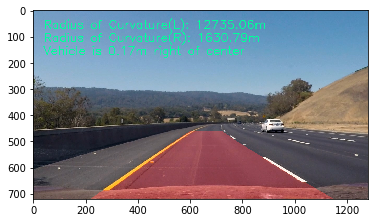

In [575]:
process_image(mpimg.imread(test_images[2]))
plt.imshow(lane_container.out_image)
print(lane_container.left_line.best_fit)
print(lane_container.right_line.best_fit[0]**2)
# plt.imshow(temp_lane.out_image)
# plt.figure()
# plt.imshow(mpimg.imread(test_images[0]))

In [73]:
sample_output = 'sample_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

[MoviePy] >>>> Building video sample_output.mp4
[MoviePy] Writing video sample_output.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  9.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_output.mp4 

CPU times: user 3min 5s, sys: 21.9 s, total: 3min 27s
Wall time: 2min 18s


In [58]:
video = io.open('sample_output.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [74]:
from numpy import random as rn

In [576]:
sample_output = 'sample_trX3.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(sample_output, audio=False)

complete
476.382576436 773.877628037 297.495051601
[MoviePy] >>>> Building video sample_trX3.mp4
[MoviePy] Writing video sample_trX3.mp4


  0%|          | 1/1261 [00:00<03:06,  6.76it/s]

complete
476.382576436 773.877628037 297.495051601


  0%|          | 2/1261 [00:00<03:10,  6.60it/s]

complete
476.461120116 773.866445828 297.405325711
curvature poblem
bootstrap


  0%|          | 3/1261 [00:00<03:03,  6.85it/s]

complete
476.565638382 775.686008107 299.120369725


  0%|          | 4/1261 [00:00<02:59,  7.01it/s]

complete
476.903458265 776.493200055 299.58974179


  0%|          | 5/1261 [00:00<03:09,  6.63it/s]

complete
477.482394433 776.953629079 299.471234646


  0%|          | 6/1261 [00:00<03:18,  6.33it/s]

complete
478.291199793 777.108814224 298.81761443


  1%|          | 7/1261 [00:01<03:15,  6.41it/s]

complete
478.725140577 775.671718705 296.946578128


  1%|          | 8/1261 [00:01<03:21,  6.22it/s]

complete
479.623340976 763.987840328 284.364499352
curvature poblem
bootstrap
complete
479.735274868 760.962806973 281.227532105
curvature poblem


  1%|          | 10/1261 [00:01<03:23,  6.16it/s]

bootstrap
complete
479.667031681 795.602571813 315.935540132
curvature poblem
bootstrap


  1%|          | 11/1261 [00:01<03:20,  6.25it/s]

complete
479.893335006 766.138901931 286.245566925
curvature poblem
bootstrap


  1%|          | 12/1261 [00:01<03:06,  6.68it/s]

complete
479.247128155 780.972453525 301.725325371


  1%|          | 13/1261 [00:01<02:56,  7.08it/s]

complete
479.454273214 775.553282755 296.099009541


  1%|          | 14/1261 [00:02<02:56,  7.08it/s]

complete
479.779419033 773.321602362 293.542183329


  1%|          | 15/1261 [00:02<02:52,  7.24it/s]

complete
480.07946985 774.611048572 294.531578723


  1%|▏         | 16/1261 [00:02<02:50,  7.29it/s]

complete
480.242688734 772.90652922 292.663840486


  1%|▏         | 17/1261 [00:02<02:46,  7.45it/s]

complete
480.501502805 773.257044982 292.755542177


  1%|▏         | 18/1261 [00:02<02:46,  7.45it/s]

complete
480.588057618 772.700591481 292.112533863


  2%|▏         | 19/1261 [00:02<02:45,  7.50it/s]

complete
480.295920173 772.858502588 292.562582414


  2%|▏         | 20/1261 [00:02<02:42,  7.64it/s]

complete
479.98504285 725.474931903 245.489889053
lane width problem


  2%|▏         | 21/1261 [00:03<02:54,  7.11it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
477.954836509 825.589618573 347.634782064
curvature poblem
bootstrap
complete
478.961277653

  2%|▏         | 23/1261 [00:03<03:03,  6.76it/s]

 735.751404121 256.790126468
curvature poblem
bootstrap
complete
477.623592615 770.29608822 292.672495605


  2%|▏         | 25/1261 [00:03<03:02,  6.79it/s]

complete
476.809330448 764.466195716 287.656865268
curvature poblem
bootstrap
complete
475.684527598 760.254860634 284.570333036
curvature poblem
bootstrap


  2%|▏         | 27/1261 [00:03<02:46,  7.41it/s]

complete
474.686909855 766.82084864 292.133938785
curvature poblem
bootstrap
complete
473.621199298 770.46357093 296.842371632


  2%|▏         | 29/1261 [00:04<02:34,  7.96it/s]

complete
471.999562874 771.302690731 299.303127857
complete
471.620502822 771.647228173 300.026725351


  2%|▏         | 31/1261 [00:04<02:26,  8.40it/s]

complete
471.105614671 771.864534806 300.758920135
complete
470.83026091 772.305729754 301.475468844


  3%|▎         | 33/1261 [00:04<02:25,  8.46it/s]

complete
470.988482879 771.074104686 300.085621807
complete
470.570330144 770.212013411 299.641683268


  3%|▎         | 35/1261 [00:04<02:32,  8.04it/s]

complete
471.14209422 762.015766539 290.873672319
curvature poblem
bootstrap
complete
471.557607646 777.522193507 305.964585861


  3%|▎         | 37/1261 [00:05<02:36,  7.83it/s]

complete
472.520378436 790.792486071 318.272107635
curvature poblem
bootstrap
complete
473.079481893 774.783054139 301.703572246


  3%|▎         | 39/1261 [00:05<02:46,  7.33it/s]

complete
473.396282322 761.526698979 288.130416657
curvature poblem
bootstrap
complete
473.781660702 774.983759262 301.20209856
curvature poblem
bootstrap


  3%|▎         | 41/1261 [00:05<02:33,  7.96it/s]

complete
473.829687447 771.103983793 297.274296346
complete
474.064219692 771.438988908 297.374769216


  3%|▎         | 43/1261 [00:05<02:34,  7.90it/s]

complete
474.704628746 772.12537326 297.420744514
curvature poblem
bootstrap
complete
475.219068657 771.627686231 296.408617574


  4%|▎         | 45/1261 [00:06<02:28,  8.18it/s]

complete
475.329967572 771.457916957 296.127949386
complete
475.610051036 771.80563617 296.195585134


  4%|▎         | 47/1261 [00:06<02:36,  7.76it/s]

complete
475.591387236 779.100488918 303.509101682
complete
475.394404794 797.598027331 322.203622537
curvature poblem
bootstrap


  4%|▍         | 49/1261 [00:06<02:34,  7.84it/s]

complete
475.991423432 830.452004832 354.4605814
curvature poblem
bootstrap
complete
475.468576902 782.170502608 306.701925706


  4%|▍         | 51/1261 [00:06<02:35,  7.80it/s]

complete
476.293660647 765.060547755 288.766887108
curvature poblem
bootstrap
complete
476.527535454 776.602957769 300.075422314


  4%|▍         | 53/1261 [00:07<02:38,  7.60it/s]

complete
476.841655067 768.533876577 291.69222151
curvature poblem
bootstrap
complete
476.962520134 771.127844847 294.165324713


  4%|▍         | 55/1261 [00:07<02:37,  7.65it/s]

complete
477.295776407 771.807706339 294.511929932
curvature poblem
bootstrap
complete
477.043884071 771.579818302 294.535934231


  5%|▍         | 57/1261 [00:07<02:29,  8.06it/s]

complete
476.739726193 771.328849603 294.58912341
complete
476.931996174 771.837540686 294.905544513


  5%|▍         | 59/1261 [00:08<02:45,  7.27it/s]

complete
477.089291948 828.62805279 351.538760842
curvature poblem
bootstrap
complete
477.265263827 753.662230712 276.396966884
curvature poblem
bootstrap


  5%|▍         | 61/1261 [00:08<02:50,  7.03it/s]

complete
477.184411458 757.408012651 280.223601192
curvature poblem
bootstrap
complete
476.178579134 777.489462843 301.310883709
curvature poblem
bootstrap


  5%|▍         | 63/1261 [00:08<02:51,  6.99it/s]

complete
475.957636575 756.178621035 280.22098446
curvature poblem
bootstrap
complete
475.042016067 758.168936878 283.126920812
curvature poblem
bootstrap


  5%|▌         | 65/1261 [00:08<02:45,  7.23it/s]

complete
474.192971895 766.539626712 292.346654817
complete
472.311378116 762.336541994 290.025163878
curvature poblem
bootstrap


  5%|▌         | 67/1261 [00:09<02:32,  7.82it/s]

complete
471.877586025 765.205907654 293.328321629
complete
470.978983032 764.997161471 294.018178439


  5%|▌         | 69/1261 [00:09<02:26,  8.11it/s]

complete
469.800639207 765.589834989 295.789195782
complete
469.301645141 765.398619387 296.096974246


  6%|▌         | 71/1261 [00:09<02:38,  7.50it/s]

complete
468.315149292 763.850126011 295.534976719
complete
468.245340848 728.896131746 260.650790898
curvature poblem
bootstrap


  6%|▌         | 73/1261 [00:09<02:46,  7.11it/s]

complete
467.762172496 726.940333489 259.178160993
curvature poblem
bootstrap
complete
468.093914116 791.011559725 322.917645609
curvature poblem
bootstrap


  6%|▌         | 75/1261 [00:10<02:45,  7.16it/s]

complete
468.629212203 759.796076905 291.166864702
complete
468.438490779 754.314284668 285.875793889
curvature poblem
bootstrap


  6%|▌         | 77/1261 [00:10<02:49,  6.97it/s]

complete
469.077150905 764.43788923 295.360738326
curvature poblem
bootstrap
complete
468.841356177 758.158332586 289.316976408
curvature poblem
bootstrap


  6%|▋         | 79/1261 [00:10<02:38,  7.47it/s]

complete
468.655389158 761.285537196 292.630148038
complete
467.838614211 760.923556006 293.084941795


  6%|▋         | 81/1261 [00:10<02:30,  7.86it/s]

complete
467.610758732 761.30371577 293.692957038
complete
466.90456743 761.01213028 294.10756285


  7%|▋         | 83/1261 [00:11<02:42,  7.23it/s]

complete
465.992286695 760.067110729 294.074824034
curvature poblem
bootstrap
complete
464.825198766 760.681313835 295.856115068
curvature poblem
bootstrap


  7%|▋         | 85/1261 [00:11<02:47,  7.01it/s]

complete
463.278489203 793.0870525 329.808563297
curvature poblem
bootstrap
complete
462.390731735 718.305690445 255.914958711
curvature poblem
bootstrap


  7%|▋         | 87/1261 [00:11<02:49,  6.91it/s]

complete
461.545068926 765.957863261 304.412794335
curvature poblem
bootstrap
complete
461.360317599 759.665524875 298.305207276
curvature poblem
bootstrap


  7%|▋         | 89/1261 [00:12<02:42,  7.22it/s]

complete
461.271961305 755.866730984 294.594769679
curvature poblem
bootstrap
complete
461.208140958 759.42572648 298.217585522


  7%|▋         | 91/1261 [00:12<02:28,  7.89it/s]

complete
461.507386051 760.75954041 299.252154359
complete
461.129443746 758.626954106 297.49751036


  7%|▋         | 93/1261 [00:12<02:24,  8.09it/s]

complete
461.890670965 759.479998943 297.589327978
complete
462.194766988 760.148113454 297.953346466


  8%|▊         | 95/1261 [00:12<02:23,  8.15it/s]

complete
462.67336575 759.62712524 296.95375949
complete
462.351558069 759.424544217 297.072986148


  8%|▊         | 97/1261 [00:13<02:40,  7.26it/s]

complete
462.620575573 745.07395921 282.453383636
curvature poblem
bootstrap
complete
463.20434277 735.400117814 272.195775043
curvature poblem
bootstrap


  8%|▊         | 99/1261 [00:13<02:48,  6.91it/s]

complete
463.425769504 769.914634997 306.488865493
curvature poblem
bootstrap
complete
464.328204077 767.927904851 303.599700775
curvature poblem
bootstrap


  8%|▊         | 101/1261 [00:13<02:37,  7.39it/s]

complete
464.52049099 743.239763641 278.719272652
curvature poblem
bootstrap
complete
465.56496926 756.780030403 291.215061143


  8%|▊         | 103/1261 [00:13<02:36,  7.38it/s]

complete
466.028182527 756.999146529 290.970964002
complete
466.414319896 752.072830233 285.658510337
curvature poblem
bootstrap


  8%|▊         | 105/1261 [00:14<02:26,  7.91it/s]

complete
466.907543743 756.032142253 289.12459851
complete
466.818107351 757.792561768 290.974454418


  8%|▊         | 107/1261 [00:14<02:21,  8.18it/s]

complete
467.021785095 760.621862094 293.600076999
complete
467.066626905 761.304474336 294.237847431


  9%|▊         | 109/1261 [00:14<02:23,  8.03it/s]

complete
467.755531922 757.43259189 289.677059967
curvature poblem
bootstrap
complete
467.778525878 770.132384045 302.353858167


  9%|▉         | 111/1261 [00:15<02:36,  7.36it/s]

complete
467.882954959 746.917429651 279.034474692
curvature poblem
bootstrap
complete
468.362757423 792.528743292 324.16598587
curvature poblem
bootstrap


  9%|▉         | 113/1261 [00:15<02:31,  7.56it/s]

complete
467.687007221 775.8941369 308.207129679
curvature poblem
bootstrap
complete
468.34927334 766.463792686 298.114519346


  9%|▉         | 115/1261 [00:15<02:30,  7.59it/s]

complete
469.041839394 770.253575093 301.211735699
curvature poblem
bootstrap
complete
469.29556805 767.877651846 298.582083796


  9%|▉         | 117/1261 [00:15<02:28,  7.72it/s]

complete
469.819316978 767.052973368 297.23365639
curvature poblem
bootstrap
complete
470.027060515 765.408791136 295.381730622


  9%|▉         | 119/1261 [00:16<02:21,  8.08it/s]

complete
470.486348576 765.455799042 294.969450465
complete
470.948194288 765.556628582 294.608434294


 10%|▉         | 121/1261 [00:16<02:17,  8.29it/s]

complete
471.771359911 764.924966451 293.15360654
complete
472.199722119 778.273082592 306.073360473


 10%|▉         | 123/1261 [00:16<02:23,  7.95it/s]

complete
472.771292545 752.518234544 279.746941999
curvature poblem
bootstrap
complete
473.491535267 755.891269617 282.39973435


 10%|▉         | 125/1261 [00:16<02:28,  7.66it/s]

complete
473.976876277 797.333106933 323.356230655
curvature poblem
bootstrap
complete
474.55317473 764.754627213 290.201452483


 10%|█         | 127/1261 [00:17<02:39,  7.12it/s]

complete
474.783798661 762.297818006 287.514019344
curvature poblem
bootstrap
complete
475.373626619 771.708515526 296.334888907
curvature poblem
bootstrap


 10%|█         | 129/1261 [00:17<02:27,  7.66it/s]

complete
475.640559059 768.571467606 292.930908548
complete
476.618353677 766.826689309 290.208335632


 10%|█         | 131/1261 [00:17<02:26,  7.69it/s]

complete
476.762399212 768.630008223 291.86760901
curvature poblem
bootstrap
complete
477.070722381 768.676444805 291.605722424


 11%|█         | 133/1261 [00:17<02:22,  7.94it/s]

complete
477.865390198 768.765463934 290.900073736
complete
478.42016597 768.856057313 290.435891344


 11%|█         | 135/1261 [00:18<02:35,  7.23it/s]

complete
479.085705823 755.864011296 276.778305473
curvature poblem
bootstrap
complete
479.658836054 738.180781684 258.52194563
curvature poblem
bootstrap


 11%|█         | 137/1261 [00:18<02:29,  7.50it/s]

complete
480.204405858 794.616704025 314.412298167
curvature poblem
bootstrap
complete
479.901275765 775.317431693 295.416155928


 11%|█         | 139/1261 [00:18<02:37,  7.10it/s]

complete
479.278487409 768.223799016 288.945311607
curvature poblem
bootstrap
complete
478.778020684 778.584817446 299.806796762
curvature poblem
bootstrap


 11%|█         | 141/1261 [00:18<02:33,  7.30it/s]

complete
478.303081759 773.51040359 295.207321831
complete
477.881271681 795.388211547 317.506939867
curvature poblem
bootstrap


 11%|█▏        | 143/1261 [00:19<02:39,  6.99it/s]

complete
477.708770142 783.149181841 305.440411699
curvature poblem
bootstrap
complete
477.443987232 778.695790388 301.251803155
curvature poblem
bootstrap


 11%|█▏        | 145/1261 [00:19<02:34,  7.20it/s]

complete
476.775357908 773.1214737 296.346115792
complete
476.608068884 773.914327819 297.306258935
curvature poblem
bootstrap


 12%|█▏        | 147/1261 [00:19<02:41,  6.91it/s]

complete
476.753187849 818.599726752 341.846538903
curvature poblem
bootstrap
complete
476.747649397 818.489522173 341.741872776
curvature poblem
bootstrap


 12%|█▏        | 149/1261 [00:20<02:42,  6.84it/s]

complete
477.49357415 818.867862756 341.374288606
curvature poblem
bootstrap
complete
477.686288614 818.820260317 341.133971703
curvature poblem
bootstrap


 12%|█▏        | 151/1261 [00:20<02:45,  6.69it/s]

complete
478.04752121 817.110933643 339.063412433
curvature poblem
bootstrap
complete
477.563921044 815.964825849 338.400904805
curvature poblem
bootstrap


 12%|█▏        | 153/1261 [00:20<02:43,  6.79it/s]

complete
477.078791364 814.479028914 337.400237549
curvature poblem
bootstrap
complete
477.246767693 800.207962671 322.961194978
curvature poblem
bootstrap


 12%|█▏        | 155/1261 [00:21<02:43,  6.78it/s]

complete
476.566182371 788.751661069 312.185478698
curvature poblem
bootstrap
complete
475.918522729 776.336277347 300.417754617
curvature poblem
bootstrap


 12%|█▏        | 157/1261 [00:21<02:43,  6.74it/s]

complete
475.383982767 779.916938476 304.532955709
curvature poblem
bootstrap
complete
474.934429716 775.01664278 300.082213063
curvature poblem
bootstrap


 13%|█▎        | 159/1261 [00:21<02:45,  6.65it/s]

complete
474.300118894 800.746708039 326.446589146
curvature poblem
bootstrap
complete
473.238223749 818.83379338 345.595569632
curvature poblem
bootstrap


 13%|█▎        | 161/1261 [00:21<02:44,  6.70it/s]

complete
472.474357628 819.291315725 346.816958098
curvature poblem
bootstrap
complete
471.82050905 819.151088519 347.330579469
curvature poblem
bootstrap


 13%|█▎        | 163/1261 [00:22<02:48,  6.52it/s]

complete
471.138031074 819.195088611 348.057057536
curvature poblem
bootstrap
complete
470.569623087 819.258963207 348.689340119
curvature poblem
bootstrap


 13%|█▎        | 165/1261 [00:22<02:51,  6.38it/s]

complete
470.561865204 815.670825016 345.108959812
curvature poblem
bootstrap
complete
470.772932755 809.90674064 339.133807885
curvature poblem
bootstrap


 13%|█▎        | 167/1261 [00:22<02:49,  6.44it/s]

complete
470.475186586 802.27715422 331.801967634
curvature poblem
bootstrap
complete
470.722561586 783.508017236 312.78545565
curvature poblem
bootstrap


 13%|█▎        | 169/1261 [00:23<02:43,  6.69it/s]

complete
470.418199221 771.665450368 301.247251147
complete
469.999706808 788.793839361 318.794132553
curvature poblem
bootstrap


 14%|█▎        | 171/1261 [00:23<02:42,  6.71it/s]

complete
469.230660302 772.699210189 303.468549888
curvature poblem
bootstrap
complete
468.831268282 818.797631315 349.966363033
curvature poblem
bootstrap


 14%|█▎        | 173/1261 [00:23<02:43,  6.66it/s]

complete
468.545591644 818.857506615 350.311914971
curvature poblem
bootstrap
complete
468.616065668 818.507057683 349.890992015
curvature poblem
bootstrap


 14%|█▍        | 175/1261 [00:24<02:30,  7.20it/s]

complete
468.914542397 819.316959924 350.402417528
curvature poblem
bootstrap
complete
468.748063641 758.881766523 290.133702882


 14%|█▍        | 177/1261 [00:24<02:29,  7.23it/s]

complete
468.531897183 765.341745303 296.809848121
complete
468.088032962 808.631276031 340.543243068
curvature poblem
bootstrap


 14%|█▍        | 179/1261 [00:24<02:27,  7.36it/s]

complete
467.885126643 764.565943776 296.680817133
complete
467.856052719 765.838694622 297.982641903
curvature poblem
bootstrap


 14%|█▍        | 181/1261 [00:24<02:19,  7.72it/s]

complete
467.569045347 766.228982592 298.659937245
complete
466.526756603 766.215439849 299.688683246


 15%|█▍        | 183/1261 [00:25<02:32,  7.05it/s]

complete
465.625316936 766.561975161 300.936658226
curvature poblem
bootstrap
complete
465.519182848 766.746984109 301.22780126
curvature poblem
bootstrap


 15%|█▍        | 185/1261 [00:25<02:37,  6.84it/s]

complete
465.121067376 578.962514798 113.841447422
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.561097483 825.194349141 363.633251659
curvature poblem
bootstrap


 15%|█▍        | 187/1261 [00:25<02:43,  6.57it/s]

complete
464.82998248 819.288993064 354.459010584
curvature poblem
bootstrap
complete
464.662244055 818.34963355 353.687389494
curvature poblem
bootstrap


 15%|█▍        | 189/1261 [00:26<02:32,  7.02it/s]

complete
464.896589571 817.061409177 352.164819606
curvature poblem
bootstrap
complete
465.654654809 766.849260145 301.194605336


 15%|█▌        | 191/1261 [00:26<02:37,  6.80it/s]

complete
466.807658916 799.869780383 333.062121467
curvature poblem
bootstrap
complete
468.357439776 793.489267602 325.131827826
curvature poblem
bootstrap


 15%|█▌        | 193/1261 [00:26<02:37,  6.76it/s]

complete
469.719766413 779.216952904 309.497186491
curvature poblem
bootstrap
complete
471.513255532 790.814053028 319.300797496
curvature poblem
bootstrap


 15%|█▌        | 195/1261 [00:26<02:38,  6.73it/s]

complete
472.908467048 805.359988491 332.451521443
curvature poblem
bootstrap
complete
473.252413512 776.168517932 302.916104421
curvature poblem
bootstrap


 16%|█▌        | 197/1261 [00:27<02:41,  6.61it/s]

complete
472.60208318 820.198174391 347.596091211
curvature poblem
bootstrap
complete
471.29214115 820.505352395 349.213211245
curvature poblem
bootstrap


 16%|█▌        | 199/1261 [00:27<02:39,  6.64it/s]

complete
470.054746035 820.384813114 350.330067079
curvature poblem
bootstrap
complete
468.93272842 820.220551466 351.287823046
curvature poblem
bootstrap


 16%|█▌        | 201/1261 [00:27<02:39,  6.65it/s]

complete
468.731426829 819.700746805 350.969319976
curvature poblem
bootstrap
complete
467.765670761 819.483109262 351.717438501
curvature poblem
bootstrap


 16%|█▌        | 203/1261 [00:28<02:40,  6.60it/s]

complete
467.533721129 816.968208316 349.434487187
curvature poblem
bootstrap
complete
467.413675349 796.485170923 329.071495574
curvature poblem
bootstrap


 16%|█▋        | 205/1261 [00:28<02:40,  6.57it/s]

complete
466.811021436 789.884641249 323.073619813
curvature poblem
bootstrap
complete
467.249056138 796.492072857 329.243016719
curvature poblem
bootstrap


 16%|█▋        | 207/1261 [00:28<02:41,  6.54it/s]

complete
467.608488013 775.666567522 308.05807951
curvature poblem
bootstrap
complete
468.426907964 780.415089958 311.988181994
curvature poblem
bootstrap


 17%|█▋        | 209/1261 [00:29<02:43,  6.45it/s]

complete
468.663773445 818.845521414 350.181747969
curvature poblem
bootstrap
complete
468.678473779 819.142482074 350.464008295
curvature poblem
bootstrap


 17%|█▋        | 211/1261 [00:29<02:42,  6.46it/s]

complete
468.311112158 819.207229426 350.896117269
curvature poblem
bootstrap
complete
467.682757588 818.724804409 351.042046821
curvature poblem
bootstrap


 17%|█▋        | 213/1261 [00:29<02:43,  6.43it/s]

complete
467.583880747 817.384546745 349.800665998
curvature poblem
bootstrap
complete
467.075709698 817.8434251 350.767715402
curvature poblem
bootstrap


 17%|█▋        | 215/1261 [00:29<02:42,  6.43it/s]

complete
466.648143146 809.023498716 342.37535557
curvature poblem
bootstrap
complete
466.045962593 796.145881733 330.099919139
curvature poblem
bootstrap


 17%|█▋        | 217/1261 [00:30<02:42,  6.43it/s]

complete
465.526914712 779.717260321 314.190345609
curvature poblem
bootstrap
complete
465.373404535 772.026437185 306.65303265
curvature poblem
bootstrap


 17%|█▋        | 219/1261 [00:30<02:26,  7.09it/s]

complete
464.981354684 767.519313902 302.537959218
complete
465.199121589 767.529726323 302.330604735


 18%|█▊        | 221/1261 [00:30<02:31,  6.88it/s]

complete
465.164292378 767.755767698 302.59147532
complete
466.044082298 818.959735777 352.915653479
curvature poblem
bootstrap


 18%|█▊        | 223/1261 [00:31<02:27,  7.01it/s]

complete
466.36896859 818.734213674 352.365245084
curvature poblem
bootstrap
complete
466.470084942 776.446816901 309.976731958


 18%|█▊        | 225/1261 [00:31<02:29,  6.92it/s]

complete
467.040819538 763.190211328 296.14939179
complete
466.51352363 757.928057776 291.414534146
curvature poblem
bootstrap


 18%|█▊        | 227/1261 [00:31<02:18,  7.44it/s]

complete
466.222804378 761.868407512 295.645603135
complete
465.749918982 763.117817287 297.367898305


 18%|█▊        | 229/1261 [00:31<02:15,  7.63it/s]

complete
465.106307814 762.227273202 297.120965388
complete
464.829797885 761.310877196 296.481079312


 18%|█▊        | 231/1261 [00:32<02:11,  7.85it/s]

complete
463.969993293 760.766688815 296.796695522
complete
463.720176014 758.529817786 294.809641772


 18%|█▊        | 233/1261 [00:32<02:20,  7.32it/s]

complete
462.833975996 756.930568727 294.09659273
complete
462.21580556 726.570003439 264.354197879
curvature poblem
bootstrap


 19%|█▊        | 235/1261 [00:32<02:27,  6.94it/s]

complete
461.604841484 734.150190276 272.545348793
curvature poblem
bootstrap
complete
460.866353692 771.380488666 310.514134974
curvature poblem
bootstrap


 19%|█▉        | 237/1261 [00:33<02:34,  6.61it/s]

complete
460.574609679 745.718689147 285.144079468
curvature poblem
bootstrap
complete
459.832463951 748.808317284 288.975853333
curvature poblem
bootstrap


 19%|█▉        | 239/1261 [00:33<02:37,  6.50it/s]

complete
459.551526421 750.346125388 290.794598966
curvature poblem
bootstrap
complete
458.893167869 750.474281757 291.581113888
curvature poblem
bootstrap


 19%|█▉        | 241/1261 [00:33<02:19,  7.31it/s]

complete
458.604431029 753.930416079 295.32598505
complete
458.22607752 753.419624268 295.193546748


 19%|█▉        | 243/1261 [00:33<02:11,  7.76it/s]

complete
457.044646039 754.889902383 297.845256344
complete
456.969659489 753.774253273 296.804593784


 19%|█▉        | 245/1261 [00:34<02:14,  7.55it/s]

complete
456.217730739 753.145069292 296.927338552
complete
455.809178753 747.085225919 291.276047166
curvature poblem
bootstrap


 20%|█▉        | 247/1261 [00:34<02:14,  7.54it/s]

complete
455.367312061 737.004283014 281.636970952
curvature poblem
bootstrap
complete
454.899308283 754.281496789 299.382188507


 20%|█▉        | 249/1261 [00:34<02:05,  8.07it/s]

complete
455.349243349 755.011212233 299.661968884
complete
454.652136466 755.796898636 301.144762169


 20%|█▉        | 251/1261 [00:34<02:02,  8.24it/s]

complete
454.525398547 756.836244452 302.310845906
complete
454.443539356 753.43136003 298.987820674


 20%|██        | 253/1261 [00:35<02:10,  7.71it/s]

complete
454.409510165 753.986818743 299.577308579
complete
454.399321688 753.073375839 298.674054152
curvature poblem
bootstrap


 20%|██        | 255/1261 [00:35<02:04,  8.08it/s]

complete
454.190964267 752.858174328 298.667210061
complete
454.937789525 752.968165698 298.030376173


 20%|██        | 257/1261 [00:35<02:01,  8.27it/s]

complete
454.531557469 752.642251944 298.110694474
complete
454.726040925 667.522706022 212.796665097
lane width problem


 20%|██        | 258/1261 [00:35<02:13,  7.53it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
453.899317539 818.033395194 364.134077655
curvature poblem
bootstrap
complete
455.097336483 727.370859686 272.273523203

 21%|██        | 260/1261 [00:36<02:27,  6.79it/s]


curvature poblem
bootstrap
complete
455.939299299 764.508791233 308.569491935
curvature poblem
bootstrap


 21%|██        | 262/1261 [00:36<02:27,  6.79it/s]

complete
456.052085161 746.380026029 290.327940868
curvature poblem
bootstrap
complete
456.698173892 744.575950805 287.877776913
curvature poblem
bootstrap


 21%|██        | 264/1261 [00:36<02:22,  7.02it/s]

complete
456.81220205 753.762882383 296.950680333
complete
456.627344002 751.424581943 294.797237941
curvature poblem
bootstrap


 21%|██        | 266/1261 [00:36<02:10,  7.61it/s]

complete
456.327821598 753.741707942 297.413886345
complete
455.488109017 755.088364389 299.600255372


 21%|██▏       | 268/1261 [00:37<02:05,  7.91it/s]

complete
455.531083315 755.343280865 299.81219755
complete
454.859939073 754.684132268 299.824193196


 21%|██▏       | 270/1261 [00:37<02:16,  7.28it/s]

complete
454.550235392 755.172406078 300.622170687
curvature poblem
bootstrap
complete
454.643469566 743.916751106 289.27328154
curvature poblem
bootstrap


 22%|██▏       | 272/1261 [00:37<02:11,  7.52it/s]

complete
454.747733933 745.466916404 290.719182471
curvature poblem
bootstrap
complete
455.830890457 757.410635319 301.579744862


 22%|██▏       | 274/1261 [00:38<02:10,  7.55it/s]

complete
456.220154606 748.295509259 292.075354653
curvature poblem
bootstrap
complete
457.141380884 757.275501209 300.134120325


 22%|██▏       | 276/1261 [00:38<02:12,  7.46it/s]

complete
457.487004983 755.604495944 298.117490961
curvature poblem
bootstrap
complete
457.551956376 759.665878043 302.113921668


 22%|██▏       | 278/1261 [00:38<02:03,  7.97it/s]

complete
457.829071177 759.801140121 301.972068945
complete
457.930332474 760.4607071 302.530374626


 22%|██▏       | 280/1261 [00:38<01:59,  8.24it/s]

complete
458.61982997 759.087421428 300.467591457
complete
459.007981302 758.221589099 299.213607797


 22%|██▏       | 282/1261 [00:39<02:02,  8.02it/s]

complete
459.706291181 760.074984033 300.368692852
complete
460.513030658 740.33418997 279.821159312
curvature poblem
bootstrap


 23%|██▎       | 284/1261 [00:39<02:02,  7.97it/s]

complete
460.906924444 767.22426541 306.317340966
complete
461.57519722 757.036966451 295.46176923
curvature poblem
bootstrap


 23%|██▎       | 286/1261 [00:39<02:01,  8.05it/s]

complete
462.060486115 757.65430508 295.593818965
curvature poblem
bootstrap
complete
462.112773446 763.917696264 301.804922819


 23%|██▎       | 288/1261 [00:39<01:53,  8.60it/s]

complete
462.536200665 763.964893581 301.428692916
complete
462.672923338 763.491311847 300.818388509


 23%|██▎       | 290/1261 [00:39<01:48,  8.94it/s]

complete
463.591986959 763.811560708 300.219573748
complete
463.417682833 764.5261955 301.108512667


 23%|██▎       | 292/1261 [00:40<01:48,  8.91it/s]

complete
464.438061902 764.108833718 299.670771816
complete
465.063671398 764.059493292 298.995821894


 23%|██▎       | 294/1261 [00:40<02:04,  7.74it/s]

complete
465.381575026 745.594441914 280.212866888
curvature poblem
bootstrap
complete
466.284350623 727.320611797 261.036261174
curvature poblem
bootstrap


 23%|██▎       | 296/1261 [00:40<02:09,  7.47it/s]

complete
466.555499572 793.242603781 326.687104209
curvature poblem
bootstrap
complete
466.846433976 755.630671123 288.784237146
curvature poblem
bootstrap


 24%|██▎       | 298/1261 [00:40<02:03,  7.82it/s]

complete
466.682175149 760.500302694 293.818127546
curvature poblem
bootstrap
complete
466.691521354 765.515693628 298.824172274


 24%|██▍       | 300/1261 [00:41<01:59,  8.05it/s]

complete
466.666566629 763.832910897 297.166344268
curvature poblem
bootstrap
complete
465.937358276 764.813600038 298.876241762


 24%|██▍       | 302/1261 [00:41<01:51,  8.62it/s]

complete
465.81092188 765.54617756 299.73525568
complete
465.52159081 766.377492156 300.855901345


 24%|██▍       | 304/1261 [00:41<01:48,  8.83it/s]

complete
465.095420798 766.143985743 301.048564945
complete
464.599215285 765.770130346 301.170915061


 24%|██▍       | 306/1261 [00:41<02:02,  7.81it/s]

complete
464.603593215 755.888151455 291.28455824
curvature poblem
bootstrap
complete
465.322895677 737.516312558 272.19341688
curvature poblem
bootstrap


 24%|██▍       | 308/1261 [00:42<02:02,  7.75it/s]

complete
465.324992527 768.326750898 303.001758371
complete
466.605856867 797.504554947 330.89869808
curvature poblem
bootstrap


 25%|██▍       | 310/1261 [00:42<02:09,  7.33it/s]

complete
466.928710244 752.328149462 285.399439218
curvature poblem
bootstrap
complete
467.676484918 765.168641794 297.492156876
curvature poblem
bootstrap


 25%|██▍       | 312/1261 [00:42<01:58,  7.99it/s]

complete
468.369084858 766.560946817 298.191861959
complete
468.528663948 766.289144744 297.760480796


 25%|██▍       | 314/1261 [00:42<01:57,  8.04it/s]

complete
469.608210587 764.402592843 294.794382256
curvature poblem
bootstrap
complete
469.507511932 765.433164846 295.925652915


 25%|██▌       | 316/1261 [00:43<01:49,  8.63it/s]

complete
469.528004012 765.350543112 295.8225391
complete
469.309617363 765.118917007 295.809299644


 25%|██▌       | 318/1261 [00:43<01:59,  7.89it/s]

complete
469.47514105 733.498286051 264.023145002
curvature poblem
bootstrap
complete
470.296011154 843.506668675 373.210657521
curvature poblem
bootstrap


 25%|██▌       | 320/1261 [00:43<02:04,  7.54it/s]

complete
470.29390398 786.532947121 316.239043141
curvature poblem
bootstrap
complete
470.668057384 768.874857073 298.206799689
curvature poblem
bootstrap


 26%|██▌       | 322/1261 [00:44<02:07,  7.36it/s]

complete
471.14066488 754.102076258 282.961411378
curvature poblem
bootstrap
complete
471.32252823 763.529328451 292.20680022
curvature poblem
bootstrap


 26%|██▌       | 324/1261 [00:44<02:07,  7.33it/s]

complete
471.748081697 761.764928852 290.016847155
curvature poblem
bootstrap
complete
471.30785679 761.770665785 290.462808994
curvature poblem
bootstrap


 26%|██▌       | 326/1261 [00:44<02:09,  7.24it/s]

complete
471.515382583 763.139451695 291.624069112
curvature poblem
bootstrap
complete
471.16187618 763.739789556 292.577913377
curvature poblem
bootstrap


 26%|██▌       | 328/1261 [00:44<02:08,  7.24it/s]

complete
470.360908947 763.974517356 293.613608408
curvature poblem
bootstrap
complete
469.794244583 763.220070574 293.425825991
curvature poblem
bootstrap


 26%|██▌       | 330/1261 [00:45<02:02,  7.60it/s]

complete
468.8716979 736.20636263 267.33466473
curvature poblem
bootstrap
complete
469.160986753 763.571349577 294.410362824


 26%|██▋       | 332/1261 [00:45<02:05,  7.41it/s]

complete
469.143750976 773.230203485 304.086452509
curvature poblem
bootstrap
complete
469.704250304 761.359398669 291.655148365
curvature poblem
bootstrap


 26%|██▋       | 334/1261 [00:45<02:05,  7.36it/s]

complete
469.611589018 753.159642454 283.548053436
curvature poblem
bootstrap
complete
469.727285621 770.62648266 300.899197039
curvature poblem
bootstrap


 27%|██▋       | 336/1261 [00:45<02:06,  7.33it/s]

complete
469.959295989 763.140524083 293.181228094
curvature poblem
bootstrap
complete
469.616357624 766.476931314 296.860573691
curvature poblem
bootstrap


 27%|██▋       | 338/1261 [00:46<02:07,  7.25it/s]

complete
469.492096981 767.639945185 298.147848205
curvature poblem
bootstrap
complete
469.22556192 767.093370896 297.867808976
curvature poblem
bootstrap


 27%|██▋       | 340/1261 [00:46<02:08,  7.15it/s]

complete
469.290943891 766.917630646 297.626686755
curvature poblem
bootstrap
complete
469.763403937 766.477802643 296.714398707
curvature poblem
bootstrap


 27%|██▋       | 342/1261 [00:46<02:09,  7.08it/s]

complete
469.846364452 788.36318182 318.516817368
curvature poblem
bootstrap
complete
470.230822519 742.283266094 272.052443575
curvature poblem
bootstrap


 27%|██▋       | 344/1261 [00:47<02:08,  7.15it/s]

complete
470.295005488 777.792797118 307.49779163
curvature poblem
bootstrap
complete
470.21813782 768.414590994 298.196453175
curvature poblem
bootstrap


 27%|██▋       | 346/1261 [00:47<02:08,  7.10it/s]

complete
470.659599736 759.620128925 288.960529189
curvature poblem
bootstrap
complete
470.539328514 766.687605127 296.148276613
curvature poblem
bootstrap


 28%|██▊       | 348/1261 [00:47<01:58,  7.69it/s]

complete
471.584991527 766.591830509 295.006838982
curvature poblem
bootstrap
complete
471.646649763 765.709494217 294.062844454


 28%|██▊       | 350/1261 [00:47<01:51,  8.19it/s]

complete
471.94272668 765.94614377 294.003417091
complete
471.537742434 766.736373947 295.198631513


 28%|██▊       | 352/1261 [00:48<01:44,  8.71it/s]

complete
471.220522569 766.609611004 295.389088435
complete
470.678354987 766.285286312 295.606931326


 28%|██▊       | 354/1261 [00:48<01:49,  8.29it/s]

complete
469.689498496 767.043271339 297.353772843
complete
469.296288309 743.786810914 274.490522605
curvature poblem
bootstrap


 28%|██▊       | 356/1261 [00:48<01:56,  7.78it/s]

complete
468.617907814 784.096705497 315.478797683
curvature poblem
bootstrap
complete
468.178708461 775.575888965 307.397180504
curvature poblem
bootstrap


 28%|██▊       | 358/1261 [00:48<01:55,  7.79it/s]

complete
468.314942664 763.014382677 294.699440013
complete
468.299966891 766.920531121 298.62056423
curvature poblem
bootstrap


 29%|██▊       | 360/1261 [00:49<01:47,  8.37it/s]

complete
469.051925406 764.428027682 295.376102277
complete
469.123634147 764.830273263 295.706639116


 29%|██▊       | 362/1261 [00:49<01:45,  8.50it/s]

complete
469.531689976 765.345804896 295.814114919
complete
470.367078748 765.10142626 294.734347512


 29%|██▉       | 364/1261 [00:49<01:43,  8.69it/s]

complete
471.349840357 765.43485328 294.085012923
complete
472.308594519 764.765402618 292.4568081


 29%|██▉       | 366/1261 [00:49<01:54,  7.85it/s]

complete
472.695773345 781.166008771 308.470235426
curvature poblem
bootstrap
complete
473.494188909 745.531935612 272.037746703
curvature poblem
bootstrap


 29%|██▉       | 368/1261 [00:50<01:55,  7.76it/s]

complete
473.857667643 763.860702081 290.003034437
complete
474.029500979 762.046822289 288.01732131
curvature poblem
bootstrap


 29%|██▉       | 370/1261 [00:50<01:52,  7.92it/s]

complete
474.306777963 755.81521061 281.508432647
curvature poblem
bootstrap
complete
474.349803213 765.543130008 291.193326795


 30%|██▉       | 372/1261 [00:50<01:44,  8.49it/s]

complete
474.032263853 764.788958244 290.756694391
complete
473.115107458 765.615199278 292.50009182


 30%|██▉       | 374/1261 [00:50<01:40,  8.79it/s]

complete
472.284521753 766.336919152 294.052397399
complete
471.509750298 766.226994576 294.717244278


 30%|██▉       | 376/1261 [00:50<01:38,  9.00it/s]

complete
470.262841867 765.837146452 295.574304585
complete
469.534920143 764.923584153 295.38866401


 30%|██▉       | 378/1261 [00:51<01:43,  8.54it/s]

complete
468.417509638 730.427261442 262.009751804
curvature poblem
bootstrap
complete
467.797335342 756.738399295 288.941063953


 30%|███       | 380/1261 [00:51<01:51,  7.89it/s]

complete
467.243714443 770.581152128 303.337437685
curvature poblem
bootstrap
complete
466.543755216 760.614208124 294.070452908
curvature poblem
bootstrap


 30%|███       | 382/1261 [00:51<01:51,  7.90it/s]

complete
466.302022012 764.109524184 297.807502172
complete
465.942441059 764.858738261 298.916297202
curvature poblem
bootstrap


 30%|███       | 384/1261 [00:51<01:48,  8.09it/s]

complete
466.078671636 760.272934882 294.194263245
curvature poblem
bootstrap
complete
465.990422498 764.331170389 298.340747891


 31%|███       | 386/1261 [00:52<01:42,  8.55it/s]

complete
466.102857584 765.010504818 298.907647234
complete
465.886776078 765.569592033 299.682815955


 31%|███       | 388/1261 [00:52<01:39,  8.80it/s]

complete
466.029460996 765.900958789 299.871497794
complete
466.723296149 765.725705903 299.002409754


 31%|███       | 390/1261 [00:52<01:46,  8.17it/s]

complete
467.00657518 765.639712444 298.633137265
complete
467.091652874 730.126963277 263.035310404
curvature poblem
bootstrap


 31%|███       | 392/1261 [00:52<01:54,  7.60it/s]

complete
468.249330129 765.392089127 297.142758998
curvature poblem
bootstrap
complete
468.07316197 766.192338412 298.119176442
curvature poblem
bootstrap


 31%|███       | 394/1261 [00:53<01:59,  7.26it/s]

complete
468.858622252 753.703539054 284.844916802
curvature poblem
bootstrap
complete
468.645973705 763.279763957 294.633790252
curvature poblem
bootstrap


 31%|███▏      | 396/1261 [00:53<01:48,  7.98it/s]

complete
468.753843746 761.83385084 293.080007095
complete
467.875224887 762.065380498 294.190155611


 32%|███▏      | 398/1261 [00:53<01:52,  7.66it/s]

complete
467.426217154 762.807758739 295.381541586
curvature poblem
bootstrap
complete
466.640474347 763.551478905 296.911004558
curvature poblem
bootstrap


 32%|███▏      | 400/1261 [00:53<01:49,  7.86it/s]

complete
465.890556337 763.761553257 297.87099692
curvature poblem
bootstrap
complete
465.160889436 763.639783922 298.478894486


 32%|███▏      | 402/1261 [00:54<01:49,  7.82it/s]

complete
464.992932933 763.95981542 298.966882487
complete
464.086259879 732.414862874 268.328602995
curvature poblem
bootstrap


 32%|███▏      | 404/1261 [00:54<01:47,  7.96it/s]

complete
464.757276548 766.624847372 301.867570824
curvature poblem
bootstrap
complete
464.150832832 758.071306075 293.920473243


 32%|███▏      | 406/1261 [00:54<01:52,  7.62it/s]

complete
464.416934133 752.587536301 288.170602168
curvature poblem
bootstrap
complete
464.31421179 763.827777522 299.513565732
curvature poblem
bootstrap


 32%|███▏      | 408/1261 [00:54<01:49,  7.76it/s]

complete
463.896778794 760.485653097 296.588874303
complete
464.446874149 759.677945029 295.23107088
curvature poblem
bootstrap


 33%|███▎      | 410/1261 [00:55<01:55,  7.40it/s]

complete
464.582857921 760.136696855 295.553838935
curvature poblem
bootstrap
complete
464.518247466 760.17930104 295.661053574
curvature poblem
bootstrap


 33%|███▎      | 412/1261 [00:55<01:50,  7.65it/s]

complete
464.010797548 759.592800081 295.582002533
curvature poblem
bootstrap
complete
463.714059341 759.206119718 295.492060377


 33%|███▎      | 414/1261 [00:55<01:54,  7.39it/s]

complete
463.010963461 784.91744821 321.906484749
curvature poblem
bootstrap
complete
462.599425858 737.976949622 275.377523764
curvature poblem
bootstrap


 33%|███▎      | 416/1261 [00:56<01:56,  7.26it/s]

complete
461.88080094 757.877170271 295.996369331
curvature poblem
bootstrap
complete
460.69348443 771.831314173 311.137829743
curvature poblem
bootstrap


 33%|███▎      | 418/1261 [00:56<01:50,  7.62it/s]

complete
460.406179347 755.559802278 295.153622931
curvature poblem
bootstrap
complete
459.621667337 756.133758363 296.512091026


 33%|███▎      | 420/1261 [00:56<01:41,  8.31it/s]

complete
459.407187033 756.527402046 297.120215014
complete
459.576858109 756.226723586 296.649865477


 33%|███▎      | 422/1261 [00:56<01:44,  8.05it/s]

complete
459.325851575 756.711164344 297.385312768
complete
459.569719012 756.41828607 296.848567058
curvature poblem
bootstrap


 34%|███▎      | 424/1261 [00:57<01:37,  8.56it/s]

complete
458.842296643 756.014690737 297.172394094
complete
458.403202705 755.639452796 297.236250092


 34%|███▍      | 426/1261 [00:57<01:48,  7.71it/s]

complete
458.348661137 781.546047515 323.197386378
curvature poblem
bootstrap
complete
457.450932776 759.378365269 301.927432493
curvature poblem
bootstrap


 34%|███▍      | 428/1261 [00:57<01:48,  7.68it/s]

complete
457.642882657 752.860794885 295.217912228
complete
457.587258885 761.963963208 304.376704323
curvature poblem
bootstrap


 34%|███▍      | 430/1261 [00:57<01:52,  7.36it/s]

complete
457.62738804 755.556011256 297.928623216
curvature poblem
bootstrap
complete
457.604686585 753.342107713 295.737421128
curvature poblem
bootstrap


 34%|███▍      | 432/1261 [00:58<01:47,  7.69it/s]

complete
456.684218505 753.016177183 296.331958678
curvature poblem
bootstrap
complete
456.722664037 751.734566423 295.011902385


 34%|███▍      | 434/1261 [00:58<01:47,  7.72it/s]

complete
455.920996422 752.543308395 296.622311973
complete
456.016343112 752.846173402 296.82983029
curvature poblem
bootstrap


 35%|███▍      | 436/1261 [00:58<01:50,  7.49it/s]

complete
455.807994495 752.659014943 296.851020448
curvature poblem
bootstrap
complete
455.485644584 752.202586938 296.716942354
curvature poblem
bootstrap


 35%|███▍      | 438/1261 [00:58<01:50,  7.44it/s]

complete
455.717763072 643.799877243 188.08211417
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.834741237 821.744298518 366.909557281
curvature poblem
bootstrap


 35%|███▍      | 440/1261 [00:59<01:54,  7.16it/s]

complete
455.658509265 751.014584204 295.35607494
curvature poblem
bootstrap
complete
455.894609232 764.67055703 308.775947799
curvature poblem
bootstrap


 35%|███▌      | 442/1261 [00:59<01:54,  7.18it/s]

complete
455.58082549 747.688716049 292.107890558
curvature poblem
bootstrap
complete
455.801071217 750.425918727 294.624847511
curvature poblem
bootstrap


 35%|███▌      | 444/1261 [00:59<01:45,  7.72it/s]

complete
454.173182187 751.464807237 297.29162505
curvature poblem
bootstrap
complete
453.980497637 749.816251249 295.835753612


 35%|███▌      | 446/1261 [00:59<01:43,  7.89it/s]

complete
453.277683363 750.991983649 297.714300286
complete
452.505844884 751.54459921 299.038754326
curvature poblem
bootstrap


 36%|███▌      | 448/1261 [01:00<01:34,  8.58it/s]

complete
453.083339236 750.741357289 297.658018053
complete
452.238659597 750.940195686 298.701536089


 36%|███▌      | 450/1261 [01:00<01:43,  7.86it/s]

complete
451.885086804 747.366421058 295.481334254
curvature poblem
bootstrap
complete
451.277403697 741.065205627 289.78780193
curvature poblem
bootstrap


 36%|███▌      | 452/1261 [01:00<01:47,  7.55it/s]

complete
450.429715228 752.732005526 302.302290298
curvature poblem
bootstrap
complete
450.181203744 761.342636248 311.161432504
curvature poblem
bootstrap


 36%|███▌      | 454/1261 [01:00<01:49,  7.34it/s]

complete
449.48191031 748.400671643 298.918761334
curvature poblem
bootstrap
complete
450.024412303 749.280106327 299.255694024
curvature poblem
bootstrap


 36%|███▌      | 456/1261 [01:01<01:39,  8.12it/s]

complete
450.055509646 750.151577812 300.096068167
complete
450.212544863 750.315655518 300.103110655


 36%|███▋      | 458/1261 [01:01<01:40,  7.96it/s]

complete
451.040014037 750.785223794 299.745209758
complete
451.604944615 751.533574683 299.928630068
curvature poblem
bootstrap


 36%|███▋      | 460/1261 [01:01<01:37,  8.19it/s]

complete
452.390983041 751.639150654 299.248167614
curvature poblem
bootstrap
complete
452.250034896 751.271396194 299.021361298


 37%|███▋      | 462/1261 [01:01<01:43,  7.68it/s]

complete
452.593146779 739.084225183 286.491078404
curvature poblem
bootstrap
complete
452.335409194 733.405332283 281.069923089
curvature poblem
bootstrap


 37%|███▋      | 464/1261 [01:02<01:51,  7.17it/s]

complete
451.912914184 760.947312394 309.03439821
curvature poblem
bootstrap
complete
452.326471311 757.987593365 305.661122054
curvature poblem
bootstrap


 37%|███▋      | 466/1261 [01:02<01:45,  7.55it/s]

complete
452.186835978 747.317010687 295.130174709
curvature poblem
bootstrap
complete
452.613666682 750.529917345 297.916250662


 37%|███▋      | 468/1261 [01:02<01:38,  8.08it/s]

complete
452.226656293 751.043995027 298.817338734
complete
452.982553719 750.991944437 298.009390718


 37%|███▋      | 470/1261 [01:02<01:32,  8.54it/s]

complete
453.318165858 751.467824276 298.149658418
complete
452.901143051 751.936455953 299.035312902


 37%|███▋      | 472/1261 [01:03<01:29,  8.79it/s]

complete
453.421634148 751.560841266 298.139207118
complete
453.459336795 751.180895685 297.72155889


 38%|███▊      | 474/1261 [01:03<01:38,  8.01it/s]

complete
454.035487041 735.143151002 281.107663961
curvature poblem
bootstrap
complete
455.086591632 727.292715082 272.206123449
curvature poblem
bootstrap


 38%|███▊      | 476/1261 [01:03<01:44,  7.55it/s]

complete
454.507024788 755.090135495 300.583110707
curvature poblem
bootstrap
complete
455.463040402 752.765499746 297.302459344
curvature poblem
bootstrap


 38%|███▊      | 478/1261 [01:04<01:49,  7.16it/s]

complete
455.916509139 751.096365076 295.179855937
curvature poblem
bootstrap
complete
456.647161829 751.501201393 294.854039564
curvature poblem
bootstrap


 38%|███▊      | 480/1261 [01:04<01:56,  6.71it/s]

complete
456.971205998 751.038427108 294.06722111
curvature poblem
bootstrap
complete
456.745843263 752.211158957 295.465315693
curvature poblem
bootstrap


 38%|███▊      | 482/1261 [01:04<01:57,  6.62it/s]

complete
457.125884709 752.144466373 295.018581664
curvature poblem
bootstrap
complete
456.272578626 753.059378318 296.786799692
curvature poblem
bootstrap


 38%|███▊      | 484/1261 [01:04<01:50,  7.03it/s]

complete
455.761533799 752.772333698 297.010799899
curvature poblem
bootstrap
complete
455.658766241 752.779408744 297.120642503


 39%|███▊      | 486/1261 [01:05<01:54,  6.74it/s]

complete
454.900308273 741.629235869 286.728927596
curvature poblem
bootstrap
complete
455.233876851 736.541446516 281.307569665
curvature poblem
bootstrap


 39%|███▊      | 488/1261 [01:05<01:57,  6.58it/s]

complete
455.061180387 760.617531731 305.556351344
curvature poblem
bootstrap
complete
455.172444924 745.148055989 289.975611065
curvature poblem
bootstrap


 39%|███▉      | 490/1261 [01:05<01:55,  6.70it/s]

complete
455.319186505 749.834966877 294.515780372
curvature poblem
bootstrap
complete
455.242307012 751.872522398 296.630215386
curvature poblem
bootstrap


 39%|███▉      | 492/1261 [01:06<01:55,  6.65it/s]

complete
455.411747482 750.38341437 294.971666888
curvature poblem
bootstrap
complete
455.295903746 754.349096176 299.05319243
curvature poblem
bootstrap


 39%|███▉      | 494/1261 [01:06<01:56,  6.61it/s]

complete
455.658522617 754.656719341 298.998196724
curvature poblem
bootstrap
complete
455.440877231 754.995556312 299.554679081
curvature poblem
bootstrap


 39%|███▉      | 496/1261 [01:06<01:55,  6.60it/s]

complete
455.464916695 755.242613326 299.777696631
curvature poblem
bootstrap
complete
455.237848535 754.748479882 299.510631347
curvature poblem
bootstrap


 39%|███▉      | 498/1261 [01:07<01:56,  6.55it/s]

complete
455.367137631 740.370530933 285.003393301
curvature poblem
bootstrap
complete
455.507995975 741.818360808 286.310364833
curvature poblem
bootstrap


 40%|███▉      | 500/1261 [01:07<01:47,  7.06it/s]

complete
454.941252151 764.169281316 309.228029166
curvature poblem
bootstrap
complete
454.043091979 755.661243945 301.618151966


 40%|███▉      | 502/1261 [01:07<01:43,  7.34it/s]

complete
454.271201419 753.555822631 299.284621212
curvature poblem
bootstrap
complete
454.294457033 757.585922588 303.291465555


 40%|███▉      | 504/1261 [01:07<01:47,  7.04it/s]

complete
454.982812413 758.247531585 303.264719172
curvature poblem
bootstrap
complete
454.992440938 758.356188337 303.363747399
curvature poblem
bootstrap


 40%|████      | 506/1261 [01:08<01:52,  6.74it/s]

complete
455.077429137 759.081459442 304.004030305
curvature poblem
bootstrap
complete
455.138510689 759.381297283 304.242786594
curvature poblem
bootstrap


 40%|████      | 508/1261 [01:08<01:46,  7.04it/s]

complete
454.480898113 759.563867885 305.082969772
curvature poblem
bootstrap
complete
454.290652709 759.095321506 304.804668797


 40%|████      | 510/1261 [01:08<01:47,  6.96it/s]

complete
453.740867211 754.410755347 300.669888136
curvature poblem
bootstrap
complete
453.856479766 740.846842609 286.990362843
curvature poblem
bootstrap


 41%|████      | 512/1261 [01:09<01:49,  6.87it/s]

complete
454.082325095 757.882982143 303.800657048
curvature poblem
bootstrap
complete
454.015042516 763.581503053 309.566460536
curvature poblem
bootstrap


 41%|████      | 514/1261 [01:09<01:40,  7.42it/s]

complete
454.569135929 751.87694259 297.307806661
curvature poblem
bootstrap
complete
455.025074017 754.91239556 299.887321543


 41%|████      | 516/1261 [01:09<01:31,  8.15it/s]

complete
455.281375173 754.626312594 299.344937421
complete
455.01595915 754.862278136 299.846318986


 41%|████      | 518/1261 [01:09<01:38,  7.56it/s]

complete
454.674152595 755.888115273 301.213962677
curvature poblem
bootstrap
complete
455.340362366 755.557430596 300.21706823
curvature poblem
bootstrap


 41%|████      | 520/1261 [01:10<01:41,  7.31it/s]

complete
455.09102248 755.88878769 300.797765209
curvature poblem
bootstrap
complete
455.92585961 755.383975663 299.458116052
curvature poblem
bootstrap


 41%|████▏     | 522/1261 [01:10<01:40,  7.35it/s]

complete
456.230873478 772.26154109 316.030667612
curvature poblem
bootstrap
complete
456.304457579 733.329930128 277.025472548
curvature poblem
bootstrap


 42%|████▏     | 524/1261 [01:10<01:41,  7.24it/s]

complete
456.311957703 752.666495974 296.354538271
curvature poblem
bootstrap
complete
455.826007985 774.263917785 318.4379098
curvature poblem
bootstrap


 42%|████▏     | 526/1261 [01:10<01:40,  7.29it/s]

complete
455.646938229 748.580116413 292.933178184
curvature poblem
bootstrap
complete
454.650111701 757.830135399 303.180023698
curvature poblem
bootstrap


 42%|████▏     | 528/1261 [01:11<01:42,  7.17it/s]

complete
454.427477962 756.282173853 301.854695891
curvature poblem
bootstrap
complete
454.188253294 757.248821559 303.060568264
curvature poblem
bootstrap


 42%|████▏     | 530/1261 [01:11<01:43,  7.08it/s]

complete
454.296575494 756.950222043 302.653646548
curvature poblem
bootstrap
complete
455.21392726 756.406181238 301.192253978
curvature poblem
bootstrap


 42%|████▏     | 532/1261 [01:11<01:39,  7.34it/s]

complete
455.851242782 754.849973055 298.998730273
complete
456.904777284 753.882186516 296.977409231
curvature poblem
bootstrap


 42%|████▏     | 534/1261 [01:12<01:39,  7.33it/s]

complete
456.952979573 764.663598114 307.710618541
curvature poblem
bootstrap
complete
457.177765919 715.074362399 257.89659648
curvature poblem
bootstrap


 43%|████▎     | 536/1261 [01:12<01:29,  8.06it/s]

complete
457.193080372 755.069794422 297.87671405
complete
458.900087181 762.827190632 303.927103451


 43%|████▎     | 538/1261 [01:12<01:24,  8.53it/s]

complete
462.66395819 757.727967829 295.064009639
complete
459.16238861 757.830031135 298.667642525


 43%|████▎     | 540/1261 [01:12<01:26,  8.31it/s]

complete
458.232610788 758.030308006 299.797697218
complete
458.1444338 757.963259469 299.818825669


 43%|████▎     | 542/1261 [01:12<01:25,  8.37it/s]

complete
457.198892997 757.655135776 300.456242779
complete
455.858098688 756.785110948 300.927012259


 43%|████▎     | 544/1261 [01:13<01:25,  8.34it/s]

complete
457.381451695 756.692371846 299.310920152
complete
457.201594973 755.995838959 298.794243986


 43%|████▎     | 546/1261 [01:13<01:36,  7.37it/s]

complete
458.093030761 758.632707339 300.539676578
curvature poblem
bootstrap
complete
458.5453394 756.491266325 297.945926925
curvature poblem
bootstrap


 43%|████▎     | 548/1261 [01:13<01:41,  7.00it/s]

complete
458.129734747 755.272167266 297.142432518
curvature poblem
bootstrap
complete
458.444925412 754.362421816 295.917496405
curvature poblem
bootstrap


 44%|████▎     | 550/1261 [01:14<01:33,  7.62it/s]

complete
466.529318473 754.472853887 287.943535415
complete
457.192320182 755.942533659 298.750213478


 44%|████▍     | 552/1261 [01:14<01:28,  7.98it/s]

complete
427.544052642 756.241555411 328.697502769
complete
455.903530454 756.545397631 300.641867178


 44%|████▍     | 554/1261 [01:14<01:27,  8.10it/s]

complete
456.093191538 757.192923792 301.099732254
complete
455.567641058 757.593706459 302.026065401


 44%|████▍     | 556/1261 [01:14<01:25,  8.28it/s]

complete
457.3212385 757.808178604 300.486940104
complete
458.283599468 757.187744621 298.904145153


 44%|████▍     | 558/1261 [01:15<01:29,  7.89it/s]

complete
457.776113837 770.968325548 313.19221171
curvature poblem
bootstrap
complete
457.525935914 757.69684728 300.170911366


 44%|████▍     | 560/1261 [01:15<01:37,  7.17it/s]

complete
454.79975001 760.971728479 306.171978469
curvature poblem
bootstrap
complete
452.353178018 766.38949097 314.036312952
curvature poblem
bootstrap


 45%|████▍     | 562/1261 [01:15<01:41,  6.86it/s]

complete
450.009407444 766.634082432 316.624674987
curvature poblem
bootstrap
complete
448.752220024 769.322484104 320.57026408
curvature poblem
bootstrap


 45%|████▍     | 564/1261 [01:15<01:44,  6.67it/s]

complete
448.825546986 767.46326505 318.637718064
curvature poblem
bootstrap
complete
449.692486745 771.241145347 321.548658602
curvature poblem
bootstrap


 45%|████▍     | 566/1261 [01:16<01:38,  7.09it/s]

complete
450.617743799 827.295222476 376.677478677
curvature poblem
bootstrap
complete
451.219705279 734.057650875 282.837945596


 45%|████▌     | 568/1261 [01:16<01:35,  7.27it/s]

complete
453.827010204 850.031489523 396.204479319
curvature poblem
bootstrap
complete
455.830372898 753.572751297 297.7423784


 45%|████▌     | 570/1261 [01:16<01:28,  7.81it/s]

complete
455.52593519 757.994945679 302.46901049
complete
456.0193704 759.558629979 303.539259579


 45%|████▌     | 572/1261 [01:17<01:24,  8.15it/s]

complete
454.598443669 757.195566152 302.597122483
complete
455.103413068 759.833279591 304.729866522


 46%|████▌     | 574/1261 [01:17<01:33,  7.35it/s]

complete
454.452878825 758.836067715 304.383188891
curvature poblem
bootstrap
complete
455.324156591 837.468547353 382.144390762
curvature poblem
bootstrap


 46%|████▌     | 576/1261 [01:17<01:36,  7.12it/s]

complete
454.657133872 851.041862038 396.384728166
curvature poblem
bootstrap
complete
455.406297112 823.585184657 368.178887545
curvature poblem
bootstrap


 46%|████▌     | 578/1261 [01:17<01:38,  6.93it/s]

complete
455.959711779 753.647539529 297.68782775
curvature poblem
bootstrap
complete
456.093864169 853.979668376 397.885804207
curvature poblem
bootstrap


 46%|████▌     | 580/1261 [01:18<01:32,  7.33it/s]

complete
455.666668731 862.514342767 406.847674036
curvature poblem
bootstrap
complete
456.098465574 737.361999182 281.263533607


 46%|████▌     | 582/1261 [01:18<01:32,  7.31it/s]

complete
456.892861618 670.0 213.107138382
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.050895305 798.865558616 344.814663311
curvature poblem
bootstrap


 46%|████▌     | 583/1261 [01:18<01:48,  6.22it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
452.971450881 788.451149403 335.479698522
curvature poblem
bootstrap
complete
456.497242413 843.859638034 387.362395622
curvature poblem


 46%|████▋     | 585/1261 [01:18<01:39,  6.79it/s]

bootstrap
complete
453.721376682 867.115839456 413.394462774


 46%|████▋     | 586/1261 [01:19<01:55,  5.83it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
456.351250159 772.86017151 316.508921351
curvature poblem
bootstrap


 47%|████▋     | 587/1261 [01:19<02:07,  5.28it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
454.209966253 775.036265921 320.826299668
curvature poblem
bootstrap


 47%|████▋     | 588/1261 [01:19<02:14,  4.99it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
454.784319864 783.821283506 329.036963642
curvature poblem
bootstrap


 47%|████▋     | 590/1261 [01:19<02:02,  5.49it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
454.415926227 820.592791416 366.176865188
curvature poblem
bootstrap
complete
435.64747947 806.0 370.35252053


 47%|████▋     | 592/1261 [01:20<01:40,  6.65it/s]

complete
432.928532265 806.0 373.071467735
complete
434.788506775 806.0 371.211493225


 47%|████▋     | 594/1261 [01:20<01:29,  7.47it/s]

complete
433.231146449 857.217240749 423.9860943
complete
430.689279619 806.0 375.310720381


 47%|████▋     | 596/1261 [01:20<01:25,  7.80it/s]

complete
425.235932857 806.0 380.764067143
complete
415.418336901 806.0 390.581663099


 47%|████▋     | 597/1261 [01:20<01:22,  8.00it/s]

complete
405.064167423 806.0 400.935832577
SLIDING:CURVATURE TOO DIFFERENT
window
fail
450.125339453 769.077052523 318.95171307
curvature poblem


 48%|████▊     | 599/1261 [01:21<01:36,  6.87it/s]

bootstrap
complete
372.555660361 806.0 433.444339639


 48%|████▊     | 600/1261 [01:21<01:31,  7.21it/s]

complete
384.409711147 805.413854342 421.004143195
SLIDING:CURVATURE TOO DIFFERENT
window
fail
447.806752783 830.702984005 382.896231222
curvature poblem


 48%|████▊     | 602/1261 [01:21<01:41,  6.51it/s]

bootstrap
complete
361.757511231 806.0 444.242488769


 48%|████▊     | 604/1261 [01:21<01:38,  6.67it/s]

complete
338.861037589 806.0 467.138962411
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
445.871560653 822.495591026 376.624030374
curvature poblem
bootstrap


 48%|████▊     | 606/1261 [01:22<01:41,  6.47it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
444.926860786 821.809099324 376.882238538
curvature poblem
bootstrap
complete
395.112189751 806.0 410.887810249


 48%|████▊     | 608/1261 [01:22<01:45,  6.18it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
441.373056455 823.07046797 381.697411515
curvature poblem
bootstrap
complete
396.37011983 806.0 409.62988017


 48%|████▊     | 610/1261 [01:22<01:31,  7.13it/s]

complete
387.164551958 806.0 418.835448042
complete
377.045060184 857.217240749 480.172180565
lane width problem


 48%|████▊     | 611/1261 [01:22<01:35,  6.79it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
436.739525175 828.192955792 391.453430617
curvature poblem
bootstrap


 49%|████▊     | 613/1261 [01:23<01:36,  6.73it/s]

complete
405.200535621 808.0 402.799464379
complete
377.014651551 807.999794281 430.98514273
curvature poblem
bootstrap


 49%|████▉     | 615/1261 [01:23<01:34,  6.82it/s]

complete
377.583354892 808.0 430.416645108
complete
374.042034742 808.0 433.957965258
curvature poblem
bootstrap


 49%|████▉     | 617/1261 [01:23<01:28,  7.25it/s]

complete
478.144900235 808.0 329.855099765
complete
441.291189008 808.0 366.708810992


 49%|████▉     | 619/1261 [01:24<01:26,  7.38it/s]

complete
391.740695655 808.0 416.259304345
complete
380.050646493 808.0 427.949353507


 49%|████▉     | 621/1261 [01:24<01:31,  6.98it/s]

complete
348.992419408 808.0 459.007580592
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
443.582515185 823.569870246 379.98735506
curvature poblem
bootstrap


 49%|████▉     | 622/1261 [01:24<01:28,  7.20it/s]

complete
373.633460149 808.0 434.366539851
SLIDING:CURVATURE TOO DIFFERENT
window
fail
432.655544257 828.365159415 

 49%|████▉     | 623/1261 [01:24<01:46,  5.98it/s]

395.709615158
curvature poblem
bootstrap
SLIDING:CURVATURE TOO DIFFERENT
window
fail
423.728321926 825.130826881

 49%|████▉     | 624/1261 [01:24<01:59,  5.34it/s]

 401.402504955
curvature poblem
bootstrap
SLIDING:CURVATURE TOO DIFFERENT
window
fail

 50%|████▉     | 626/1261 [01:25<01:55,  5.51it/s]


426.751197368 811.480065195 384.728867827
curvature poblem
bootstrap
complete
390.684403784 949.198695712 558.514291928
lane width problem


 50%|████▉     | 627/1261 [01:25<01:51,  5.69it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
435.706196008 818.304865626 382.598669618
curvature poblem
bootstrap


 50%|████▉     | 628/1261 [01:25<02:01,  5.20it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
449.548338203 787.771302971 338.222964768
curvature poblem
bootstrap


 50%|████▉     | 629/1261 [01:25<02:09,  4.86it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
448.955837085 824.025369646 375.06953256
curvature poblem
bootstrap


 50%|████▉     | 630/1261 [01:26<02:15,  4.66it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
446.353100237 826.764314116 380.411213879
curvature poblem
bootstrap


 50%|█████     | 631/1261 [01:26<02:18,  4.56it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
443.43956625 819.80618601 376.36661976
curvature poblem
bootstrap


 50%|█████     | 632/1261 [01:26<02:20,  4.47it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
441.910789457 827.972077402 386.061287946
curvature poblem
bootstrap


 50%|█████     | 633/1261 [01:26<02:22,  4.41it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
440.295994908 827.596568577 387.300573669
curvature poblem
bootstrap


 50%|█████     | 634/1261 [01:27<02:23,  4.36it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
440.289154137 812.662834401 372.373680265
curvature poblem
bootstrap


 50%|█████     | 635/1261 [01:27<02:24,  4.34it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
443.910379032 801.376550949 357.466171917
curvature poblem
bootstrap


 50%|█████     | 636/1261 [01:27<02:24,  4.34it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
446.790804387 775.180984082 328.390179695
curvature poblem
bootstrap


 51%|█████     | 637/1261 [01:27<02:24,  4.32it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
450.504237095 761.670856066 311.166618971
curvature poblem
bootstrap


 51%|█████     | 638/1261 [01:28<02:24,  4.30it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
452.723981321 758.071957805 305.347976484
curvature poblem
bootstrap


 51%|█████     | 639/1261 [01:28<02:24,  4.31it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
452.149570296 760.719093494 308.569523199
curvature poblem
bootstrap


 51%|█████     | 640/1261 [01:28<02:17,  4.51it/s]

SLIDING:CURVATURE accepted
window
fail
452.592872631 763.594822739 311.001950108


 51%|█████     | 641/1261 [01:28<02:21,  4.38it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
451.111592778 776.402966465 325.291373687
curvature poblem
bootstrap


 51%|█████     | 642/1261 [01:28<02:22,  4.34it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
451.516267027 824.527969154 373.011702127
curvature poblem
bootstrap


 51%|█████     | 643/1261 [01:29<02:23,  4.31it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
452.653018398 824.027631991 371.374613593
curvature poblem
bootstrap


 51%|█████     | 644/1261 [01:29<02:24,  4.28it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
453.944528864 820.888165815 366.943636951
curvature poblem
bootstrap
complete
456.049939257 763.000000001

 51%|█████▏    | 647/1261 [01:29<01:46,  5.76it/s]

 306.950060744
complete
457.623715594 759.999999999 302.376284405
complete
458.290427885 716.145654566 257.855226682
curvature poblem
bootstrap


 51%|█████▏    | 649/1261 [01:30<01:38,  6.23it/s]

complete
458.87243093 619.842364532 160.969933602
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.42610062 788.120849768 329.694749148
curvature poblem
bootstrap


 52%|█████▏    | 651/1261 [01:30<01:37,  6.28it/s]

complete
459.350325361 755.350073553 295.999748192
curvature poblem
bootstrap
complete
459.660869696 727.295095333 267.634225637
curvature poblem
bootstrap


 52%|█████▏    | 652/1261 [01:30<01:49,  5.54it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
461.092378646 765.030526557 303.938147911
curvature poblem
bootstrap


 52%|█████▏    | 653/1261 [01:30<01:59,  5.09it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
461.377338788 769.441193857 308.063855069
curvature poblem
bootstrap
complete
462.097477113

 52%|█████▏    | 655/1261 [01:31<01:45,  5.76it/s]

 641.999999989 179.902522876
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
464.382410754 822.861826897 358.479416143
curvature poblem
bootstrap


 52%|█████▏    | 656/1261 [01:31<01:56,  5.19it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
465.652438775 819.892489519 354.240050744
curvature poblem
bootstrap
complete

 52%|█████▏    | 658/1261 [01:31<01:44,  5.76it/s]


465.300002826 1755.32445572 1290.0244529
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.651473166 818.07065746 350.419184294
curvature poblem
bootstrap
complete
466.002060732 762.567553871 296.565493138
curvature poblem


 52%|█████▏    | 660/1261 [01:32<01:40,  5.96it/s]

bootstrap
complete
466.587229224 752.326952731 285.739723506
curvature poblem
bootstrap


 52%|█████▏    | 662/1261 [01:32<01:27,  6.86it/s]

complete
466.949978597 755.879727157 288.929748559
complete
466.861674683 757.141141962 290.279467279


 53%|█████▎    | 664/1261 [01:32<01:19,  7.51it/s]

complete
466.64495111 757.790991423 291.146040314
complete
466.421150524 758.43986153 292.018711006


 53%|█████▎    | 665/1261 [01:32<01:21,  7.27it/s]

complete
466.504790005 752.402973174 285.898183169
curvature poblem
bootstrap
SLIDING:CURVATURE TOO DIFFERENT


 53%|█████▎    | 667/1261 [01:33<01:32,  6.44it/s]

window
fail
466.029484761 777.966137629 311.936652868
curvature poblem
bootstrap
complete
466.336206253 1308.59453415 842.258327893
lane width problem


 53%|█████▎    | 668/1261 [01:33<01:33,  6.34it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.449548192 825.6509621 360.201413908
curvature poblem
bootstrap
complete
465.568701925 799.396678529 333.827976605
curvature poblem


 53%|█████▎    | 670/1261 [01:33<01:27,  6.76it/s]

bootstrap
complete
465.251226365 3000.17519265 2534.92396628
lane width problem


 53%|█████▎    | 672/1261 [01:33<01:24,  6.95it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
464.868932568 826.459833263 361.590900695
curvature poblem
bootstrap
complete
465.445128571 755.147221281 289.70209271


 53%|█████▎    | 674/1261 [01:34<01:17,  7.56it/s]

complete
465.298891147 760.198626898 294.899735752
complete
465.579854332 760.588984621 295.009130289


 54%|█████▎    | 676/1261 [01:34<01:23,  7.03it/s]

complete
465.736899028 761.948452471 296.211553443
curvature poblem
bootstrap
complete
466.1230371 762.799125848 296.676088748
curvature poblem
bootstrap


 54%|█████▍    | 678/1261 [01:34<01:24,  6.94it/s]

complete
465.910967973 772.729798947 306.818830974
curvature poblem
bootstrap
complete
465.978118106 818.461538462 352.483420356
curvature poblem
bootstrap


 54%|█████▍    | 679/1261 [01:34<01:39,  5.85it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
466.548733674 817.628312668 351.079578994
curvature poblem
bootstrap


 54%|█████▍    | 680/1261 [01:35<01:50,  5.28it/s]

SLIDING:CURVATURE TOO DIFFERENT
window
fail
466.991983644 721.685424545 254.693440901
curvature poblem
bootstrap
complete
466.949503548 1255.98267998 789.033176432


 54%|█████▍    | 683/1261 [01:35<01:29,  6.44it/s]

lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.635151331 827.204728241 359.56957691
curvature poblem
bootstrap
complete
467.266249355 705.552855653 238.286606298
lane width problem


 54%|█████▍    | 684/1261 [01:35<01:30,  6.36it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.935539474 842.629018914 374.693479441
curvature poblem
bootstrap
complete
467.764134099 762.940393291 295.176259192
curvature poblem


 54%|█████▍    | 686/1261 [01:36<01:32,  6.23it/s]

bootstrap
complete
468.165232224 759.150741152 290.985508928
curvature poblem
bootstrap


 55%|█████▍    | 688/1261 [01:36<01:24,  6.79it/s]

complete
468.517388662 761.551641084 293.034252422
complete
468.508664148 761.182243731 292.673579583
curvature poblem
bootstrap


 55%|█████▍    | 690/1261 [01:36<01:22,  6.88it/s]

complete
468.565928356 761.704252199 293.138323844
complete
468.721094565 743.148548627 274.427454062
curvature poblem
bootstrap


 55%|█████▍    | 692/1261 [01:36<01:19,  7.14it/s]

complete
468.722013112 825.805781124 357.083768011
curvature poblem
bootstrap
complete
469.003199986 1367.6045371 898.601337113
lane width problem


 55%|█████▍    | 693/1261 [01:37<01:24,  6.76it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.024740044 795.332605278 324.307865234
curvature poblem
bootstrap


 55%|█████▌    | 694/1261 [01:37<01:27,  6.47it/s]

complete
468.658646365 743.887754028 275.229107663
curvature poblem
bootstrap
complete
468.768507821 808.741376035 339.972868214
curvature poblem


 55%|█████▌    | 696/1261 [01:37<01:30,  6.21it/s]

bootstrap
complete
468.492945452 756.384461468 287.891516016
curvature poblem
bootstrap


 55%|█████▌    | 698/1261 [01:37<01:30,  6.23it/s]

complete
469.253408709 755.082737564 285.829328855
curvature poblem
bootstrap
complete
469.300438995 759.541631353 290.241192358
curvature poblem
bootstrap


 56%|█████▌    | 700/1261 [01:38<01:22,  6.80it/s]

complete
469.9346333 759.44527466 289.51064136
complete
470.298883879 759.664799123 289.365915244


 56%|█████▌    | 702/1261 [01:38<01:26,  6.49it/s]

complete
470.561900736 760.345604867 289.783704131
curvature poblem
bootstrap
complete
470.245357963 761.682146682 291.436788719
curvature poblem
bootstrap


 56%|█████▌    | 704/1261 [01:38<01:17,  7.23it/s]

complete
469.808327011 760.54253913 290.73421212
complete
469.462731777 747.699353492 278.236621715


 56%|█████▌    | 706/1261 [01:38<01:18,  7.04it/s]

complete
468.496439176 795.631060386 327.134621209
curvature poblem
bootstrap
complete
467.794254446 750.393209665 282.598955219
curvature poblem
bootstrap


 56%|█████▌    | 708/1261 [01:39<01:12,  7.64it/s]

complete
467.023892878 756.413581049 289.389688171
complete
466.335331419 756.470213274 290.134881855


 56%|█████▋    | 710/1261 [01:39<01:11,  7.73it/s]

complete
466.023227653 766.075162146 300.051934493
curvature poblem
bootstrap
complete
465.787873417 760.534538313 294.746664896


 56%|█████▋    | 712/1261 [01:39<01:16,  7.19it/s]

complete
465.756812369 760.864598447 295.107786078
curvature poblem
bootstrap
complete
465.566886941 760.744213086 295.177326144
curvature poblem
bootstrap


 57%|█████▋    | 714/1261 [01:40<01:18,  7.01it/s]

complete
465.944443249 761.164657074 295.220213825
curvature poblem
bootstrap
complete
466.654754586 759.244280453 292.589525868
curvature poblem
bootstrap


 57%|█████▋    | 716/1261 [01:40<01:11,  7.65it/s]

complete
467.129539061 759.011357374 291.881818313
complete
467.720095598 696.530868436 228.810772838
lane width problem


 57%|█████▋    | 718/1261 [01:40<01:12,  7.48it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.366446926 882.869574206 415.50312728
curvature poblem
bootstrap
complete
467.389391423 749.809246732 282.419855309


 57%|█████▋    | 720/1261 [01:40<01:09,  7.81it/s]

complete
467.453419548 751.000526634 283.547107086
complete
467.141784949 753.274704718 286.132919769


 57%|█████▋    | 722/1261 [01:41<01:10,  7.66it/s]

complete
467.189831726 759.03345216 291.843620434
complete
467.123633941 759.404829417 292.281195476
curvature poblem
bootstrap


 57%|█████▋    | 723/1261 [01:41<01:12,  7.46it/s]

complete
467.337644858 760.492270641 293.154625783
curvature poblem
bootstrap
complete
467.320745705 760.491541177 293.170795472
curvature poblem


 57%|█████▋    | 725/1261 [01:41<01:22,  6.46it/s]

bootstrap
complete
467.45525608 761.468420041 294.013163961
curvature poblem
bootstrap


 58%|█████▊    | 727/1261 [01:41<01:25,  6.28it/s]

complete
468.313117051 761.355492512 293.042375461
curvature poblem
bootstrap
complete
468.880900613 762.558618789 293.677718176
curvature poblem
bootstrap


 58%|█████▊    | 729/1261 [01:42<01:25,  6.20it/s]

complete
469.443892295 726.879808207 257.435915912
curvature poblem
bootstrap
complete
469.597318346 794.535998264 324.938679918
curvature poblem
bootstrap


 58%|█████▊    | 731/1261 [01:42<01:25,  6.17it/s]

complete
470.278781523 799.207569388 328.928787865
curvature poblem
bootstrap
complete
471.354105115 755.182580655 283.828475541
curvature poblem
bootstrap


 58%|█████▊    | 733/1261 [01:42<01:21,  6.49it/s]

complete
472.147972456 764.496475146 292.34850269
curvature poblem
bootstrap
complete
472.98431222 763.095545026 290.111232805


 58%|█████▊    | 735/1261 [01:43<01:16,  6.88it/s]

complete
473.371729587 763.441899556 290.07016997
complete
473.585538563 764.248645421 290.663106858


 58%|█████▊    | 736/1261 [01:43<01:21,  6.44it/s]

complete
474.045857009 765.829368155 291.783511146
curvature poblem
bootstrap
complete
473.94491738 765.041840764 291.096923384
curvature poblem


 59%|█████▊    | 738/1261 [01:43<01:25,  6.13it/s]

bootstrap
complete
474.098447724 765.070556901 290.972109178
curvature poblem
bootstrap


 59%|█████▊    | 740/1261 [01:43<01:20,  6.49it/s]

complete
474.457015816 764.589735249 290.132719433
complete
475.076625985 742.62941506 267.552789075
curvature poblem
bootstrap


 59%|█████▉    | 742/1261 [01:44<01:21,  6.38it/s]

complete
475.343091249 785.36401256 310.020921311
curvature poblem
bootstrap
complete
475.848018549 782.036477496 306.188458947
curvature poblem
bootstrap


 59%|█████▉    | 744/1261 [01:44<01:17,  6.71it/s]

complete
476.228233356 777.368176345 301.139942989
curvature poblem
bootstrap
complete
476.792595612 762.67161676 285.879021149


 59%|█████▉    | 746/1261 [01:44<01:12,  7.12it/s]

complete
476.929895668 765.441724888 288.511829221
complete
477.160088372 766.12932814 288.969239767


 59%|█████▉    | 748/1261 [01:45<01:14,  6.91it/s]

complete
477.796171594 767.014860966 289.218689372
complete
478.220342017 768.485037309 290.264695292
curvature poblem
bootstrap


 59%|█████▉    | 750/1261 [01:45<01:13,  6.93it/s]

complete
478.552790759 769.007961473 290.455170714
curvature poblem
bootstrap
complete
479.135726366 768.720101004 289.584374638


 60%|█████▉    | 752/1261 [01:45<01:19,  6.44it/s]

complete
479.591100735 769.437353296 289.846252561
curvature poblem
bootstrap
complete
480.265523629 774.31197152 294.046447891
curvature poblem
bootstrap


 60%|█████▉    | 754/1261 [01:46<01:21,  6.23it/s]

complete
480.769949674 794.906936901 314.136987227
curvature poblem
bootstrap
complete
481.609038792 781.644437102 300.03539831
curvature poblem
bootstrap


 60%|█████▉    | 756/1261 [01:46<01:14,  6.75it/s]

complete
482.627881684 766.676161189 284.048279505
complete
483.063505891 767.755365688 284.691859797


 60%|██████    | 758/1261 [01:46<01:11,  7.08it/s]

complete
484.015595578 769.206379375 285.190783797
complete
484.450475011 770.933727735 286.483252724


 60%|██████    | 760/1261 [01:46<01:13,  6.83it/s]

complete
485.178583265 772.175897575 286.99731431
complete
485.753565527 773.56187791 287.808312382
curvature poblem
bootstrap


 60%|██████    | 762/1261 [01:47<01:16,  6.55it/s]

complete
485.916439488 774.0999554 288.183515912
curvature poblem
bootstrap
complete
485.992146389 774.804519654 288.812373265
curvature poblem
bootstrap


 61%|██████    | 764/1261 [01:47<01:18,  6.32it/s]

complete
486.098728882 775.526333084 289.427604202
curvature poblem
bootstrap
complete
486.288295847 785.319088501 299.030792654
curvature poblem
bootstrap


 61%|██████    | 766/1261 [01:47<01:18,  6.34it/s]

complete
486.556496465 787.951229073 301.394732607
curvature poblem
bootstrap
complete
486.915235738 775.82007531 288.904839573
curvature poblem
bootstrap


 61%|██████    | 768/1261 [01:48<01:18,  6.30it/s]

complete
487.424250686 776.781951702 289.357701016
curvature poblem
bootstrap
complete
488.014405931 764.376710874 276.362304943
curvature poblem
bootstrap


 61%|██████    | 770/1261 [01:48<01:10,  6.96it/s]

complete
489.319344603 770.344717481 281.025372878
complete
489.99927911 772.991573473 282.992294363


 61%|██████    | 772/1261 [01:48<01:07,  7.27it/s]

complete
490.075689373 775.137525486 285.061836113
complete
489.903761377 778.027400169 288.123638793


 61%|██████▏   | 774/1261 [01:49<01:07,  7.18it/s]

complete
489.149498047 779.794410862 290.644912815
curvature poblem
bootstrap
complete
489.010259331 780.974508806 291.964249475


 62%|██████▏   | 776/1261 [01:49<01:06,  7.32it/s]

complete
488.587162233 782.068553499 293.481391266
complete
488.496565868 770.557253743 282.060687875


 62%|██████▏   | 778/1261 [01:49<01:11,  6.75it/s]

complete
488.421957666 793.737549354 305.315591688
curvature poblem
bootstrap
complete
488.095302432 763.687405575 275.592103144
curvature poblem
bootstrap


 62%|██████▏   | 780/1261 [01:49<01:09,  6.88it/s]

complete
487.944184237 791.806416232 303.862231996
curvature poblem
bootstrap
complete
487.654258966 779.573140135 291.918881169


 62%|██████▏   | 782/1261 [01:50<01:06,  7.23it/s]

complete
487.394032078 781.147429013 293.753396935
complete
486.788573546 781.771418899 294.982845353


 62%|██████▏   | 784/1261 [01:50<01:04,  7.42it/s]

complete
486.743001473 782.010105997 295.267104524
complete
486.634933474 783.33752416 296.702590685


 62%|██████▏   | 786/1261 [01:50<01:10,  6.78it/s]

complete
486.336925011 783.939533829 297.602608818
curvature poblem
bootstrap
complete
486.723100937 784.426011282 297.702910346
curvature poblem
bootstrap


 62%|██████▏   | 788/1261 [01:51<01:09,  6.82it/s]

complete
486.909442836 784.567688503 297.658245667
curvature poblem
bootstrap
complete
487.208849338 765.326334275 278.117484938


 63%|██████▎   | 790/1261 [01:51<01:12,  6.53it/s]

complete
487.646417617 795.309618146 307.663200529
curvature poblem
bootstrap
complete
488.104183354 761.211867502 273.107684148
curvature poblem
bootstrap


 63%|██████▎   | 792/1261 [01:51<01:07,  6.99it/s]

complete
488.478499487 780.682600889 292.204101403
complete
488.528503588 780.846850385 292.318346797


 63%|██████▎   | 794/1261 [01:51<01:10,  6.66it/s]

complete
488.775692342 779.902028397 291.126336055
complete
488.538530337 780.325544063 291.787013726
curvature poblem
bootstrap


 63%|██████▎   | 796/1261 [01:52<01:11,  6.53it/s]

complete
488.91510788 779.255621597 290.340513716
complete
489.301811689 779.578998246 290.277186557
curvature poblem
bootstrap


 63%|██████▎   | 798/1261 [01:52<01:09,  6.68it/s]

complete
489.203370458 779.300411257 290.097040799
curvature poblem
bootstrap
complete
489.226471886 778.889875317 289.663403431


 63%|██████▎   | 800/1261 [01:52<01:07,  6.84it/s]

complete
488.929100265 780.225477271 291.296377007
curvature poblem
bootstrap
complete
488.536084305 776.221775634 287.685691329


 64%|██████▎   | 802/1261 [01:53<01:10,  6.50it/s]

complete
487.574938541 796.287073406 308.712134865
curvature poblem
bootstrap
complete
486.886028723 786.703201494 299.817172771
curvature poblem
bootstrap


 64%|██████▎   | 803/1261 [01:53<01:12,  6.35it/s]

complete
486.348666286 797.21450754 310.865841254
curvature poblem
bootstrap
complete
486.578521022 785.446641066 298.868120044
curvature poblem


 64%|██████▍   | 805/1261 [01:53<01:17,  5.92it/s]

bootstrap
complete
487.222303287 777.165602648 289.943299361
curvature poblem
bootstrap


 64%|██████▍   | 807/1261 [01:54<01:16,  5.92it/s]

complete
487.693549379 776.490161051 288.796611673
curvature poblem
bootstrap
complete
487.891024069 777.147302591 289.256278522
curvature poblem
bootstrap


 64%|██████▍   | 809/1261 [01:54<01:15,  5.97it/s]

complete
488.78771008 777.758752913 288.971042833
curvature poblem
bootstrap
complete
488.876042389 778.558884265 289.682841876
curvature poblem
bootstrap


 64%|██████▍   | 811/1261 [01:54<01:09,  6.45it/s]

complete
488.62283841 777.886496092 289.263657682
curvature poblem
bootstrap
complete
488.361802103 777.925612438 289.563810336


 64%|██████▍   | 813/1261 [01:54<01:08,  6.57it/s]

complete
487.289439594 770.25683439 282.967394796
complete
486.309005129 807.982444131 321.673439001
curvature poblem
bootstrap


 65%|██████▍   | 815/1261 [01:55<01:03,  7.01it/s]

complete
484.885933791 775.962536766 291.076602975
complete
484.04418831 772.266643034 288.222454723


 65%|██████▍   | 817/1261 [01:55<01:01,  7.26it/s]

complete
483.99397524 774.92743092 290.93345568
complete
483.587878283 775.269774193 291.681895911


 65%|██████▍   | 819/1261 [01:55<01:00,  7.32it/s]

complete
483.176816064 775.089438258 291.912622194
complete
483.022712091 776.035416894 293.012704803


 65%|██████▌   | 821/1261 [01:56<00:59,  7.34it/s]

complete
482.059657833 775.745886076 293.686228243
complete
480.958731464 775.69816433 294.739432866


 65%|██████▌   | 823/1261 [01:56<01:03,  6.93it/s]

complete
479.589398806 775.953647846 296.36424904
complete
477.91711591 749.040547798 271.123431888
curvature poblem
bootstrap


 65%|██████▌   | 825/1261 [01:56<01:07,  6.50it/s]

complete
476.622096973 752.377034515 275.754937542
curvature poblem
bootstrap
complete
475.063494187 795.411417399 320.347923212
curvature poblem
bootstrap


 66%|██████▌   | 827/1261 [01:56<01:07,  6.41it/s]

complete
474.601042339 770.684224168 296.083181828
curvature poblem
bootstrap
complete
473.656462257 770.962227176 297.305764919
curvature poblem
bootstrap


 66%|██████▌   | 829/1261 [01:57<01:08,  6.30it/s]

complete
473.282594162 765.609134186 292.326540024
curvature poblem
bootstrap
complete
473.074114611 766.123428783 293.049314172
curvature poblem
bootstrap


 66%|██████▌   | 831/1261 [01:57<01:08,  6.30it/s]

complete
472.782348565 765.079123003 292.296774438
curvature poblem
bootstrap
complete
472.819443843 764.89997815 292.080534307
curvature poblem
bootstrap


 66%|██████▌   | 833/1261 [01:57<01:09,  6.15it/s]

complete
472.747009071 764.350330957 291.603321885
curvature poblem
bootstrap
complete
472.655913146 763.400548761 290.744635615
curvature poblem
bootstrap


 66%|██████▌   | 835/1261 [01:58<01:07,  6.30it/s]

complete
471.98927366 763.572212781 291.58293912
complete
471.356985786 769.147887475 297.790901689
curvature poblem
bootstrap


 66%|██████▋   | 837/1261 [01:58<01:05,  6.47it/s]

complete
470.58331515 753.279235076 282.695919926
complete
469.641487723 762.909528639 293.268040916
curvature poblem
bootstrap


 67%|██████▋   | 839/1261 [01:58<01:00,  7.02it/s]

complete
469.160314766 761.222866653 292.062551887
complete
468.392029837 760.995986131 292.603956295


 67%|██████▋   | 841/1261 [01:59<01:04,  6.56it/s]

complete
467.007946242 760.021047112 293.01310087
curvature poblem
bootstrap
complete
466.09166093 759.539802403 293.448141473
curvature poblem
bootstrap


 67%|██████▋   | 843/1261 [01:59<01:04,  6.48it/s]

complete
464.767362832 760.021053186 295.253690354
curvature poblem
bootstrap
complete
463.82236872 759.160126838 295.337758118
curvature poblem
bootstrap


 67%|██████▋   | 845/1261 [01:59<01:01,  6.73it/s]

complete
462.644247954 759.163296671 296.519048717
curvature poblem
bootstrap
complete
461.349786331 758.136735125 296.786948795


 67%|██████▋   | 847/1261 [02:00<01:02,  6.61it/s]

complete
461.096103569 757.635084504 296.538980935
complete
459.841945816 764.160176649 304.318230834
curvature poblem
bootstrap


 67%|██████▋   | 849/1261 [02:00<01:03,  6.54it/s]

complete
458.586461498 745.471521166 286.885059668
complete
457.770374497 757.543119369 299.772744872
curvature poblem
bootstrap


 67%|██████▋   | 851/1261 [02:00<00:59,  6.89it/s]

complete
457.080131518 756.252216875 299.172085357
complete
456.823077265 756.13658954 299.313512275


 68%|██████▊   | 853/1261 [02:00<00:59,  6.90it/s]

complete
456.067362656 762.437071782 306.369709127
curvature poblem
bootstrap
complete
455.622862513 755.439908501 299.817045988


 68%|██████▊   | 855/1261 [02:01<00:56,  7.16it/s]

complete
455.304827555 757.022791396 301.717963841
complete
454.825991943 758.126815069 303.300823126


 68%|██████▊   | 857/1261 [02:01<00:54,  7.39it/s]

complete
454.646029882 758.082438826 303.436408944
complete
454.589451488 758.319509636 303.730058148


 68%|██████▊   | 859/1261 [02:01<00:57,  6.99it/s]

complete
454.171796208 758.272603096 304.100806888
complete
454.244177962 726.722590409 272.478412447
curvature poblem
bootstrap


 68%|██████▊   | 861/1261 [02:02<01:00,  6.56it/s]

complete
453.664894748 743.717971682 290.053076934
curvature poblem
bootstrap
complete
454.294253038 759.709106697 305.414853659
curvature poblem
bootstrap


 68%|██████▊   | 862/1261 [02:02<01:02,  6.41it/s]

complete
454.982953154 757.608422262 302.625469108
curvature poblem
bootstrap
complete
455.055042778 756.940639845 301.885597067
curvature poblem
bootstrap


 69%|██████▊   | 865/1261 [02:02<01:02,  6.30it/s]

complete
455.829801965 758.042170128 302.212368163
curvature poblem
bootstrap
complete
456.090106927 758.509121944 302.419015017
curvature poblem
bootstrap


 69%|██████▉   | 867/1261 [02:03<01:03,  6.25it/s]

complete
456.682209807 758.430164719 301.747954912
curvature poblem
bootstrap
complete
456.784704121 759.181763965 302.397059845
curvature poblem
bootstrap


 69%|██████▉   | 869/1261 [02:03<01:02,  6.25it/s]

complete
456.703028363 758.682209168 301.979180806
curvature poblem
bootstrap
complete
456.689000176 758.544946513 301.855946337
curvature poblem
bootstrap


 69%|██████▉   | 871/1261 [02:03<00:59,  6.58it/s]

complete
455.945165075 759.132554186 303.187389111
curvature poblem
bootstrap
complete
455.951371736 750.84488919 294.893517454


 69%|██████▉   | 873/1261 [02:03<00:58,  6.61it/s]

complete
455.243393477 751.421059723 296.177666246
complete
454.884337773 775.52671764 320.642379867
curvature poblem
bootstrap


 69%|██████▉   | 874/1261 [02:04<01:00,  6.37it/s]

complete
454.602918856 767.41603406 312.813115205
curvature poblem
bootstrap
complete
454.891752342 755.661464445 300.769712103
curvature poblem
bootstrap

 70%|██████▉   | 877/1261 [02:04<00:57,  6.65it/s]


complete
456.031766682 756.846640521 300.814873839
curvature poblem
bootstrap
complete
456.480571789 757.607777422 301.127205633


 70%|██████▉   | 879/1261 [02:04<00:53,  7.08it/s]

complete
456.587307453 758.378841977 301.791534524
complete
457.077419177 758.881487634 301.804068457


 70%|██████▉   | 881/1261 [02:05<00:51,  7.33it/s]

complete
457.249582216 759.321969872 302.072387656
complete
457.245519381 759.470730147 302.225210766


 70%|███████   | 883/1261 [02:05<00:50,  7.47it/s]

complete
455.791057004 753.707048124 297.91599112
complete
455.256569425 692.993863621 237.737294196
lane width problem


 70%|███████   | 885/1261 [02:05<00:53,  7.07it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.32701787 1149.11206301 694.785045138
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
453.874553969 1118.83666074 664.962106771
lane width problem


 70%|███████   | 886/1261 [02:05<00:54,  6.86it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.568568347 631.256949927 176.68838158
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.302667814 780.652083043 326.349415229
curvature poblem


 70%|███████   | 888/1261 [02:06<00:56,  6.61it/s]

bootstrap
complete
456.367453065 680.371591568 224.004138503
lane width problem


 70%|███████   | 889/1261 [02:06<00:58,  6.35it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
455.855335558 770.674368832 314.819033274
curvature poblem
bootstrap
complete
455.773564699 726.438159469 270.66459477
curvature poblem


 71%|███████   | 891/1261 [02:06<00:59,  6.19it/s]

bootstrap
complete
455.41487333 733.830826086 278.415952756
curvature poblem
bootstrap


 71%|███████   | 893/1261 [02:06<00:59,  6.20it/s]

complete
455.141744158 744.703196144 289.561451986
curvature poblem
bootstrap
complete
455.356831825 750.474513096 295.117681271
curvature poblem
bootstrap


 71%|███████   | 895/1261 [02:07<00:55,  6.56it/s]

complete
455.816441035 1660.17237359 1204.35593256
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
456.57645125 1130.16470473 673.588253478
lane width problem


 71%|███████   | 897/1261 [02:07<00:55,  6.61it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
457.94112252 1120.78020793 662.839085412
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.276506737 616.05337369 157.776866953
lane width problem


 71%|███████   | 898/1261 [02:07<00:54,  6.68it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
459.666703873 638.391474526 178.724770653
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.062104415 777.264425271 316.202320856
curvature poblem


 71%|███████▏  | 900/1261 [02:08<00:58,  6.18it/s]

bootstrap
complete
461.274555799 721.833750768 260.55919497
curvature poblem
bootstrap
complete
462.276186703 718.006222698 255.730035995
curvature poblem


 72%|███████▏  | 902/1261 [02:08<00:57,  6.19it/s]

bootstrap
complete
462.171925926 745.982472844 283.810546918
curvature poblem
bootstrap


 72%|███████▏  | 904/1261 [02:08<00:56,  6.35it/s]

complete
462.401022546 752.195449043 289.794426496
curvature poblem
bootstrap
complete
462.485619239 752.093488536 289.607869297
curvature poblem
bootstrap


 72%|███████▏  | 906/1261 [02:08<00:51,  6.96it/s]

complete
462.655640361 755.677751911 293.02211155
curvature poblem
bootstrap
complete
463.146590282 1009.94971737 546.803127084
lane width problem


 72%|███████▏  | 908/1261 [02:09<00:48,  7.30it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.989123841 627.520412949 165.531289109
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.893403716 1113.98031155 652.086907838
lane width problem


 72%|███████▏  | 910/1261 [02:09<00:46,  7.52it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
462.665754413 621.639161876 158.973407463
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
463.468862682 644.324082779 180.855220097
lane width problem


 72%|███████▏  | 912/1261 [02:09<00:45,  7.59it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
464.294241104 774.784522661 310.490281557
curvature poblem
bootstrap
complete
461.608579433 678.094278308 216.485698875
lane width problem


 72%|███████▏  | 913/1261 [02:09<00:48,  7.17it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
464.310299705 766.247116182 301.936816478
curvature poblem
bootstrap
complete
462.298917398 730.898999512 268.600082114
curvature poblem


 73%|███████▎  | 915/1261 [02:10<00:49,  6.94it/s]

bootstrap
complete
462.573862148 727.53301613 264.959153982
curvature poblem
bootstrap


 73%|███████▎  | 917/1261 [02:10<00:50,  6.86it/s]

complete
463.203086119 748.673569609 285.47048349
curvature poblem
bootstrap
complete
462.843222832 761.577423553 298.734200721
curvature poblem
bootstrap


 73%|███████▎  | 919/1261 [02:10<00:47,  7.26it/s]

complete
462.44413348 1052.98188738 590.537753904
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
460.930487621 1134.34406903 673.413581407
lane width problem


 73%|███████▎  | 921/1261 [02:11<00:46,  7.39it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
459.931415459 1125.88555214 665.95413668
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
459.245309526 634.292563764 175.047254238
lane width problem


 73%|███████▎  | 923/1261 [02:11<00:44,  7.55it/s]

SLIDING:CURVATURE accepted
window-notdetected
458.164522525 659.441530658 201.277008133
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
457.568926737 686.694198468 229.12527173
lane width problem


 73%|███████▎  | 925/1261 [02:11<00:42,  7.83it/s]

SLIDING:CURVATURE accepted
window-notdetected
457.466994707 708.707115073 251.240120366
complete
458.072093937 702.117622596 244.045528659
lane width problem


 74%|███████▎  | 927/1261 [02:11<00:44,  7.59it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
457.731427972 725.616520664 267.885092692
curvature poblem
bootstrap
complete
457.219723636 740.915144996 283.69542136


 74%|███████▎  | 929/1261 [02:12<00:45,  7.27it/s]

complete
456.642925762 766.715021967 310.072096205
complete
456.511641995 869.703418136 413.191776142
curvature poblem
bootstrap


 74%|███████▍  | 931/1261 [02:12<00:45,  7.27it/s]

complete
456.160938758 898.931781584 442.770842826
curvature poblem
bootstrap
complete
455.71409544 916.403485815 460.689390375
lane width problem


 74%|███████▍  | 933/1261 [02:12<00:43,  7.54it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.635851537 1119.34112311 664.705271571
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
455.504988309 645.956250955 190.451262646
lane width problem


 74%|███████▍  | 935/1261 [02:12<00:42,  7.72it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
455.44819875 678.509210032 223.061011283
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
456.83409276 694.922983961 238.088891201
lane width problem


 74%|███████▍  | 936/1261 [02:13<00:44,  7.35it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
457.759552585 719.22081635 261.461263765
curvature poblem
bootstrap
complete
458.648480353 710.337403267 251.688922914
curvature poblem


 74%|███████▍  | 938/1261 [02:13<00:46,  6.94it/s]

bootstrap
complete
459.420308322 724.43350975 265.013201427
curvature poblem
bootstrap


 75%|███████▍  | 940/1261 [02:13<00:48,  6.58it/s]

complete
459.950974993 729.940499455 269.989524462
curvature poblem
bootstrap
complete
460.193127268 734.356542144 274.163414876
curvature poblem
bootstrap


 75%|███████▍  | 942/1261 [02:13<00:47,  6.71it/s]

complete
460.800205574 588.556824303 127.756618729
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.79230937 1168.36776642 706.575457046
lane width problem


 75%|███████▍  | 944/1261 [02:14<00:47,  6.69it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.944574088 1156.2654068 694.320832712
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.9234834 1134.95611942 673.032636021
lane width problem


 75%|███████▌  | 946/1261 [02:14<00:45,  6.85it/s]

SLIDING:CURVATURE accepted
window-notdetected
461.971152591 651.69912172 189.72796913
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.69429772 674.564656041 212.870358321
lane width problem


 75%|███████▌  | 948/1261 [02:14<00:44,  7.06it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.628346943 696.399675307 234.771328364
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
462.127737155 752.423285157 290.295548001


 75%|███████▌  | 950/1261 [02:15<00:47,  6.58it/s]

complete
461.702782422 720.801056234 259.098273812
curvature poblem
bootstrap
complete
460.753106638 737.119267113 276.366160475
curvature poblem
bootstrap


 75%|███████▌  | 952/1261 [02:15<00:47,  6.56it/s]

complete
460.098886151 754.325043301 294.22615715
complete
458.610126137 768.302852328 309.692726191
curvature poblem
bootstrap


 76%|███████▌  | 954/1261 [02:15<00:48,  6.36it/s]

complete
458.789132791 712.913304352 254.124171562
curvature poblem
bootstrap
complete
457.892881171 824.95408219 367.061201019
curvature poblem
bootstrap


 76%|███████▌  | 956/1261 [02:16<00:46,  6.59it/s]

complete
457.844134536 777.702541164 319.858406628
curvature poblem
bootstrap
complete
458.377942384 696.678557625 238.300615241
lane width problem


 76%|███████▌  | 958/1261 [02:16<00:44,  6.82it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
458.211018529 668.76466716 210.553648631
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
459.997202483 686.544513721 226.547311238
lane width problem


 76%|███████▌  | 959/1261 [02:16<00:47,  6.40it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
460.469208657 713.584438798 253.115230141
curvature poblem
bootstrap


 76%|███████▌  | 961/1261 [02:16<00:49,  6.08it/s]

complete
462.069297819 714.91134785 252.842050031
curvature poblem
bootstrap
complete
463.315220582 739.926351918 276.611131335
curvature poblem
bootstrap


 76%|███████▋  | 963/1261 [02:17<00:49,  6.08it/s]

complete
464.027590579 750.595109236 286.567518657
curvature poblem
bootstrap
complete
464.952499418 774.452433452 309.499934033
curvature poblem
bootstrap


 77%|███████▋  | 965/1261 [02:17<00:48,  6.05it/s]

complete
465.757787002 775.356150618 309.598363616
curvature poblem
bootstrap
complete
465.818229505 860.827755138 395.009525633
curvature poblem
bootstrap


 77%|███████▋  | 967/1261 [02:17<00:48,  6.12it/s]

complete
466.617654676 796.587619076 329.9699644
curvature poblem
bootstrap
complete
466.643304264 776.727652793 310.084348528
curvature poblem
bootstrap


 77%|███████▋  | 969/1261 [02:18<00:44,  6.50it/s]

complete
467.536176189 768.530111871 300.993935683
curvature poblem
bootstrap
complete
468.977103548 720.058662846 251.081559298


 77%|███████▋  | 971/1261 [02:18<00:44,  6.50it/s]

complete
469.620315238 677.763356223 208.143040985
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.685277513 731.796933324 264.111655811
curvature poblem
bootstrap


 77%|███████▋  | 973/1261 [02:18<00:45,  6.27it/s]

complete
468.900460141 729.533786999 260.633326857
curvature poblem
bootstrap
complete
470.497681548 747.723010024 277.225328476
curvature poblem
bootstrap


 77%|███████▋  | 975/1261 [02:19<00:45,  6.33it/s]

complete
470.078473066 759.689154347 289.61068128
curvature poblem
bootstrap
complete
468.701470842 767.995009588 299.293538746
curvature poblem
bootstrap


 77%|███████▋  | 977/1261 [02:19<00:42,  6.76it/s]

complete
469.127377208 134.104934708 -335.0224425
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.807119697 604.789203085 134.982083387
lane width problem


 78%|███████▊  | 979/1261 [02:19<00:42,  6.68it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
470.807715748 1505.21941981 1034.41170406
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.753660331 1201.00897602 729.255315692
lane width problem


 78%|███████▊  | 981/1261 [02:19<00:42,  6.62it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
473.551291241 1501.76244257 1028.21115133
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.965022716 687.065918325 214.100895609
lane width problem


 78%|███████▊  | 982/1261 [02:20<00:41,  6.66it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
478.019368001 714.041872347 236.022504345
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
479.805691036 733.299400543 253.493709507
curvature poblem
bootstrap

 78%|███████▊  | 985/1261 [02:20<00:44,  6.27it/s]


complete
479.405854481 745.219043721 265.81318924
curvature poblem
bootstrap
complete
477.114762769 751.974170655 274.859407886
curvature poblem
bootstrap


 78%|███████▊  | 986/1261 [02:20<00:43,  6.26it/s]

complete
478.41598795 760.051455814 281.635467863
curvature poblem
bootstrap
complete
452.06501244 768.048269614 315.983257174
curvature poblem
bootstrap


 78%|███████▊  | 989/1261 [02:21<00:41,  6.48it/s]

complete
466.204496171 805.604890389 339.400394218
curvature poblem
bootstrap
complete
409.343103992 1393.19390268 983.850798686
lane width problem


 79%|███████▊  | 991/1261 [02:21<00:40,  6.68it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
457.196741272 1157.06732704 699.870585765
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.09785908 690.329213516 223.231354436
lane width problem


 79%|███████▊  | 992/1261 [02:21<00:42,  6.38it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.425827658 796.808054653 325.382226995
curvature poblem
bootstrap
complete

 79%|███████▉  | 995/1261 [02:22<00:39,  6.77it/s]


444.520935831 689.630343281 245.10940745
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
470.520120994 775.4239876 304.903866605
curvature poblem
bootstrap
complete
470.467624564 699.966633398 229.499008834
lane width problem


 79%|███████▉  | 997/1261 [02:22<00:38,  6.86it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.1748901 770.315607747 298.140717647
curvature poblem
bootstrap
complete
471.814773475 765.204629068 293.389855593


 79%|███████▉  | 999/1261 [02:22<00:36,  7.27it/s]

complete
470.328787504 765.896072534 295.56728503
complete
467.917766156 764.891482025 296.973715868


 79%|███████▉  | 1001/1261 [02:22<00:37,  7.02it/s]

complete
465.322582258 763.786357917 298.463775659
complete
461.80189636 818.009869148 356.207972788
curvature poblem
bootstrap


 80%|███████▉  | 1003/1261 [02:23<00:39,  6.57it/s]

complete
456.670664911 817.568854711 360.8981898
curvature poblem
bootstrap
complete
452.817953518 813.639559126 360.821605608
curvature poblem
bootstrap


 80%|███████▉  | 1005/1261 [02:23<00:39,  6.44it/s]

complete
450.379856111 833.180561889 382.800705779
curvature poblem
bootstrap
complete
449.718451727 841.831741921 392.113290193
curvature poblem
bootstrap


 80%|███████▉  | 1007/1261 [02:23<00:40,  6.31it/s]

complete
453.304991913 797.401660978 344.096669065
curvature poblem
bootstrap
complete
453.013617914 776.961307351 323.947689437
curvature poblem
bootstrap


 80%|████████  | 1009/1261 [02:24<00:41,  6.14it/s]

complete
453.362101763 767.632143579 314.270041815
curvature poblem
bootstrap
complete
453.182616001 765.774440399 312.591824397
curvature poblem
bootstrap


 80%|████████  | 1011/1261 [02:24<00:40,  6.18it/s]

complete
451.277114463 773.671516977 322.394402514
curvature poblem
bootstrap
complete
449.667429026 762.919802628 313.252373602
curvature poblem
bootstrap


 80%|████████  | 1013/1261 [02:24<00:39,  6.33it/s]

complete
447.225451369 762.744807747 315.519356378
curvature poblem
bootstrap
complete
444.622488535 761.306849312 316.684360777
curvature poblem
bootstrap


 80%|████████  | 1015/1261 [02:25<00:37,  6.59it/s]

complete
443.506060215 760.22135573 316.715295515
complete
443.231723967 805.704116569 362.472392601
curvature poblem
bootstrap


 81%|████████  | 1017/1261 [02:25<00:33,  7.23it/s]

complete
445.074837748 749.538892174 304.464054426
complete
445.472584888 751.691680258 306.21909537


 81%|████████  | 1019/1261 [02:25<00:35,  6.74it/s]

complete
444.90513724 768.787242041 323.882104801
curvature poblem
bootstrap
complete
444.230673154 764.868827873 320.638154719
curvature poblem
bootstrap


 81%|████████  | 1021/1261 [02:26<00:33,  7.18it/s]

complete
443.37297889 761.929801379 318.556822488
complete
442.705385363 758.591182338 315.885796975


 81%|████████  | 1023/1261 [02:26<00:32,  7.39it/s]

complete
442.647892857 757.858755966 315.210863109
complete
440.526689017 756.921083884 316.394394867


 81%|████████▏ | 1025/1261 [02:26<00:32,  7.27it/s]

complete
440.403998289 758.054988824 317.650990535
curvature poblem
bootstrap
complete
437.487603278 758.125854822 320.638251544


 81%|████████▏ | 1027/1261 [02:26<00:34,  6.75it/s]

complete
437.640174669 828.488970808 390.848796139
curvature poblem
bootstrap
complete
449.573518991 829.058288334 379.484769343
curvature poblem
bootstrap


 82%|████████▏ | 1028/1261 [02:27<00:35,  6.51it/s]

complete
470.190401514 821.938824546 351.748423032
curvature poblem
bootstrap
complete
482.536807905 816.854949837 334.318141932
curvature poblem
bootstrap

 82%|████████▏ | 1030/1261 [02:27<00:37,  6.09it/s]


complete
469.394422606 815.049907608 345.655485002
curvature poblem
bootstrap
complete
417.518718342 818.791298827 401.272580486
curvature poblem
bootstrap

 82%|████████▏ | 1033/1261 [02:27<00:36,  6.30it/s]


complete
360.77864654 806.108244643 445.329598103
curvature poblem
bootstrap
complete
283.099994681 758.360953861 475.26095918
lane width problem


 82%|████████▏ | 1035/1261 [02:28<00:34,  6.56it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
431.368721324 761.940680129 330.571958804
complete
238.610141667 777.969622946 539.35948128
lane width problem


 82%|████████▏ | 1036/1261 [02:28<00:36,  6.18it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.287033456 757.437036417 303.150002961
curvature poblem
bootstrap


 82%|████████▏ | 1038/1261 [02:28<00:34,  6.37it/s]

complete
244.702650535 783.288406099 538.585755564
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
470.325711944 739.777354707 269.451642762


 82%|████████▏ | 1040/1261 [02:28<00:34,  6.49it/s]

complete
468.60588134 555.716213719 87.1103323781
lane width problem
SLIDING:CURVATURE accepted
window-notdetected
453.528436559 735.317634618 281.78919806


 83%|████████▎ | 1042/1261 [02:29<00:34,  6.40it/s]

complete
444.745471025 635.338722599 190.593251574
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
424.665052174 659.193034927 234.527982754
lane width problem


 83%|████████▎ | 1044/1261 [02:29<00:33,  6.50it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
418.124901881 558.241690736 140.116788855
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
438.208768256 665.929180099 227.720411842
lane width problem


 83%|████████▎ | 1046/1261 [02:29<00:32,  6.53it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
444.065621213 658.699231294 214.633610081
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.343385103 668.820984778 197.477599676
lane width problem


 83%|████████▎ | 1047/1261 [02:30<00:33,  6.43it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.801642367 702.719913085 247.918270718
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
445.432051743 764.240831591 318.808779848
curvature poblem


 83%|████████▎ | 1049/1261 [02:30<00:33,  6.26it/s]

bootstrap
complete
461.884444034 746.518341483 284.633897449


 83%|████████▎ | 1051/1261 [02:30<00:31,  6.74it/s]

complete
427.88751651 741.144389066 313.256872556
complete
407.126604825 709.227862188 302.101257364


 84%|████████▎ | 1053/1261 [02:30<00:28,  7.23it/s]

complete
400.719209555 699.693177733 298.973968178
complete
438.074002915 711.236025202 273.162022287


 84%|████████▎ | 1055/1261 [02:31<00:29,  6.88it/s]

complete
460.303652686 682.399475409 222.095822723
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
434.575191826 770.780664107 336.205472281
curvature poblem
bootstrap


 84%|████████▍ | 1057/1261 [02:31<00:28,  7.27it/s]

complete
447.963414449 723.101230841 275.137816392
complete
433.90432542 742.207038382 308.302712962


 84%|████████▍ | 1059/1261 [02:31<00:26,  7.63it/s]

complete
426.563114048 742.829161867 316.266047819
complete
409.195447565 761.166388629 351.970941064


 84%|████████▍ | 1061/1261 [02:32<00:26,  7.54it/s]

complete
399.984065239 721.758136981 321.774071743
complete
395.254813286 642.478756856 247.22394357
lane width problem


 84%|████████▍ | 1062/1261 [02:32<00:27,  7.11it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
454.697741426 819.922468303 365.224726877
curvature poblem
bootstrap


 84%|████████▍ | 1065/1261 [02:32<00:28,  6.79it/s]

complete
382.467746023 642.448204682 259.980458659
complete
354.555635998 573.458905027 218.903269029
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
455.440626439 796.743304539 341.3026781
curvature poblem
bootstrap


 85%|████████▍ | 1067/1261 [02:32<00:27,  7.07it/s]

complete
383.28023569 701.999613309 318.719377619
complete
389.782991183 720.354320573 330.57132939


 85%|████████▍ | 1069/1261 [02:33<00:27,  7.02it/s]

complete
377.562784621 736.770922728 359.208138106
curvature poblem
bootstrap
complete
381.459409467 741.335750179 359.876340712


 85%|████████▍ | 1071/1261 [02:33<00:25,  7.32it/s]

complete
391.06946422 749.560450258 358.490986038
complete
388.003669153 801.581296576 413.577627423


 85%|████████▌ | 1073/1261 [02:33<00:26,  7.01it/s]

complete
385.192066652 1098.57322926 713.381162607
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
456.430971713 819.410843753 362.97987204
curvature poblem
bootstrap


 85%|████████▌ | 1075/1261 [02:34<00:26,  6.91it/s]

complete
384.010118419 917.121295487 533.111177068
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
457.985125956 809.022589494 351.037463538
curvature poblem
bootstrap


 85%|████████▌ | 1077/1261 [02:34<00:27,  6.72it/s]

complete
389.065266397 1210.92657546 821.861309063
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.804096559 795.137874739 333.333778179
curvature poblem
bootstrap


 86%|████████▌ | 1079/1261 [02:34<00:26,  6.76it/s]

complete
394.74932452 1001.97224548 607.222920961
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
464.726656539 776.299593717 311.572937177
curvature poblem
bootstrap


 86%|████████▌ | 1081/1261 [02:34<00:25,  7.06it/s]

complete
393.137781901 1038.96488698 645.827105076
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.902303467 1183.94652687 718.044223399
lane width problem


 86%|████████▌ | 1083/1261 [02:35<00:25,  6.87it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.942879546 1154.74224064 688.799361096
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.618306538 805.296418497 338.678111959
curvature poblem
bootstrap


 86%|████████▌ | 1085/1261 [02:35<00:25,  6.77it/s]

complete
399.905859884 1530.3162841 1130.41042421
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.92256735 825.521445305 359.598877956
curvature poblem
bootstrap


 86%|████████▌ | 1087/1261 [02:35<00:26,  6.63it/s]

complete
396.702736759 1490.75360779 1094.05087103
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.557104588 814.864839737 349.307735149
curvature poblem
bootstrap


 86%|████████▋ | 1089/1261 [02:36<00:26,  6.45it/s]

complete
407.027586603 1589.84059585 1182.81300924
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.183402969 795.225886576 328.042483607
curvature poblem
bootstrap


 87%|████████▋ | 1091/1261 [02:36<00:26,  6.48it/s]

complete
390.48538777 1582.70199088 1192.21660311
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.738400133 778.699096016 310.960695883
curvature poblem
bootstrap


 87%|████████▋ | 1093/1261 [02:36<00:24,  6.88it/s]

complete
395.464925831 1572.01901007 1176.55408424
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.321068145 1243.5906432 776.269575056
lane width problem


 87%|████████▋ | 1094/1261 [02:36<00:25,  6.57it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.387273786 783.925264008 316.537990222
curvature poblem
bootstrap
complete

 87%|████████▋ | 1097/1261 [02:37<00:23,  6.98it/s]


403.837837846 1600.02716883 1196.18933098
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
468.246502412 818.29024353 350.043741118
curvature poblem
bootstrap
complete
398.681905096 1588.7668238 1190.0849187
lane width problem


 87%|████████▋ | 1099/1261 [02:37<00:23,  6.94it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
468.754438551 808.632789428 339.878350878
curvature poblem
bootstrap
complete
409.809543696 1628.91525375 1219.10571005
lane width problem


 87%|████████▋ | 1101/1261 [02:37<00:23,  6.89it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.885464979 797.243770671 327.358305692
curvature poblem
bootstrap
complete
398.431648161 1618.63357934 1220.20193118
lane width problem


 87%|████████▋ | 1102/1261 [02:38<00:25,  6.26it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.310593511 779.086440006 309.775846495
curvature poblem
bootstrap


 88%|████████▊ | 1104/1261 [02:38<00:24,  6.52it/s]

complete
404.880610173 1627.35546997 1222.4748598
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.686164958 1177.10879286 705.422627904
lane width problem


 88%|████████▊ | 1105/1261 [02:38<00:23,  6.67it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.269688533 1160.6300071 688.360318568
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
473.858033974 798.964940235 325.10690626
curvature poblem


 88%|████████▊ | 1107/1261 [02:38<00:24,  6.29it/s]

bootstrap
complete
411.365455582 1675.25587 1263.89041442
lane width problem


 88%|████████▊ | 1108/1261 [02:39<00:25,  5.96it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
475.485207177 814.11040804 338.625200863
curvature poblem
bootstrap


 88%|████████▊ | 1110/1261 [02:39<00:25,  5.98it/s]

complete
409.202350766 1695.09816941 1285.89581865
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
475.764918347 810.663016112 334.898097765
curvature poblem
bootstrap


 88%|████████▊ | 1112/1261 [02:39<00:24,  6.17it/s]

complete
404.084091107 1693.10577461 1289.0216835
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
474.962488162 795.722352224 320.759864062
curvature poblem
bootstrap


 88%|████████▊ | 1114/1261 [02:40<00:23,  6.19it/s]

complete
409.727573654 1628.41429545 1218.68672179
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
473.732398913 780.67408315 306.941684237
curvature poblem
bootstrap


 89%|████████▊ | 1116/1261 [02:40<00:21,  6.71it/s]

complete
406.880257997 1602.293037 1195.412779
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.91096757 1190.44799287 717.537025299
lane width problem


 89%|████████▊ | 1118/1261 [02:40<00:21,  6.81it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.74348716 1126.65468197 653.911194805
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.61747627 817.345494367 344.728018097
curvature poblem
bootstrap


 89%|████████▉ | 1120/1261 [02:40<00:20,  6.72it/s]

complete
405.168110549 1535.38092447 1130.21281392
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.064604066 811.701105705 339.636501638
curvature poblem
bootstrap


 89%|████████▉ | 1122/1261 [02:41<00:20,  6.75it/s]

complete
412.781691016 1581.55575178 1168.77406076
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
470.788382368 795.809756722 325.021374353
curvature poblem
bootstrap


 89%|████████▉ | 1124/1261 [02:41<00:20,  6.79it/s]

complete
432.84311062 1545.66577219 1112.82266157
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
470.675400927 784.118113394 313.442712467
curvature poblem
bootstrap


 89%|████████▉ | 1126/1261 [02:41<00:19,  6.92it/s]

complete
433.069218272 1533.13646968 1100.06725141
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
470.872063969 772.8559027 301.983838731
curvature poblem
bootstrap


 89%|████████▉ | 1128/1261 [02:41<00:18,  7.35it/s]

complete
431.898881854 1558.40135635 1126.50247449
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.038967973 1128.88251103 657.843543059
lane width problem


 90%|████████▉ | 1129/1261 [02:42<00:19,  6.94it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.477830935 821.11445765 349.636626715
curvature poblem
bootstrap
complete

 90%|████████▉ | 1132/1261 [02:42<00:18,  7.01it/s]


419.949806503 1520.39713117 1100.44732466
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
471.940993609 813.404163737 341.463170128
curvature poblem
bootstrap
complete
403.940118426 1522.95993052 1119.01981209
lane width problem


 90%|████████▉ | 1134/1261 [02:42<00:18,  6.91it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
470.887833904 803.104636018 332.216802114
curvature poblem
bootstrap
complete
407.719923405 1483.11422254 1075.39429913
lane width problem


 90%|█████████ | 1135/1261 [02:43<00:19,  6.56it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
468.762546005 789.635895625 320.873349619
curvature poblem
bootstrap
complete

 90%|█████████ | 1138/1261 [02:43<00:18,  6.72it/s]


403.101267586 1447.99414749 1044.8928799
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.643692856 774.495105477 306.851412621
curvature poblem
bootstrap
complete
393.026634473 1464.96952988 1071.9428954
lane width problem


 90%|█████████ | 1140/1261 [02:43<00:18,  6.60it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.547362101 1224.41272358 757.865361476
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.177274527 793.638362129 327.461087602
curvature poblem
bootstrap


 91%|█████████ | 1142/1261 [02:44<00:18,  6.52it/s]

complete
402.82120968 1448.87465208 1046.0534424
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.027105166 808.674676852 342.647571686
curvature poblem
bootstrap


 91%|█████████ | 1144/1261 [02:44<00:17,  6.50it/s]

complete
393.168875461 1479.20435041 1086.03547494
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
467.544539754 809.479657797 341.935118044
curvature poblem
bootstrap


 91%|█████████ | 1146/1261 [02:44<00:17,  6.58it/s]

complete
384.287262989 1465.70600641 1081.41874342
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.075825967 790.683464524 321.607638557
curvature poblem
bootstrap


 91%|█████████ | 1148/1261 [02:44<00:16,  6.66it/s]

complete
398.89371581 1500.13050241 1101.2367866
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.868009814 776.970494473 307.10248466
curvature poblem
bootstrap


 91%|█████████ | 1150/1261 [02:45<00:15,  7.10it/s]

complete
413.616177608 1523.54200442 1109.92582681
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
468.994588107 1192.18202181 723.1874337
lane width problem


 91%|█████████▏| 1151/1261 [02:45<00:15,  7.20it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.394089556 1161.61181707 692.217727509
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
468.062914302 823.857345617 355.794431315
curvature poblem


 91%|█████████▏| 1153/1261 [02:45<00:15,  6.77it/s]

bootstrap
complete
405.463875302 1507.48962895 1102.02575364
lane width problem


 92%|█████████▏| 1154/1261 [02:45<00:16,  6.47it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.801514334 813.22043501 346.418920676
curvature poblem
bootstrap
complete

 92%|█████████▏| 1157/1261 [02:46<00:15,  6.76it/s]


422.538822865 1491.14937673 1068.61055386
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.95796936 798.862646236 331.904676877
curvature poblem
bootstrap
complete
428.14386155 1487.17636931 1059.03250776
lane width problem


 92%|█████████▏| 1159/1261 [02:46<00:14,  6.81it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.896313329 784.048425039 318.15211171
curvature poblem
bootstrap
complete
425.967789356 1475.89517725 1049.92738789
lane width problem


 92%|█████████▏| 1161/1261 [02:46<00:14,  6.83it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.956242834 772.701172535 306.744929702
curvature poblem
bootstrap
complete
418.371369657 1455.26716432 1036.89579466
lane width problem


 92%|█████████▏| 1163/1261 [02:47<00:14,  6.68it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.833819609 1131.02469256 665.190872954
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.166431616 821.992772977 355.826341362
curvature poblem
bootstrap


 92%|█████████▏| 1165/1261 [02:47<00:14,  6.71it/s]

complete
421.588970743 1412.53430763 990.945336888
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.856514307 815.39401184 349.537497533
curvature poblem
bootstrap


 93%|█████████▎| 1167/1261 [02:47<00:13,  6.77it/s]

complete
433.031874962 1431.52860479 998.496729826
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
465.367456847 797.70940152 332.341944673
curvature poblem
bootstrap


 93%|█████████▎| 1169/1261 [02:48<00:13,  6.75it/s]

complete
450.927503852 1441.06315456 990.135650711
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
463.092418822 781.809623707 318.717204885
curvature poblem
bootstrap


 93%|█████████▎| 1171/1261 [02:48<00:13,  6.69it/s]

complete
437.622250173 1407.69184571 970.069595536
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
462.329626107 768.577872887 306.24824678
curvature poblem
bootstrap


 93%|█████████▎| 1173/1261 [02:48<00:12,  7.15it/s]

complete
426.130870041 1368.93850469 942.807634645
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
460.261724475 1121.33521299 661.07348852
lane width problem


 93%|█████████▎| 1174/1261 [02:48<00:12,  7.23it/s]

SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
461.66768978 1150.50954472 688.841854943
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
462.321009841 813.24330482 350.922294979
curvature poblem
bootstrap

 93%|█████████▎| 1177/1261 [02:49<00:12,  6.87it/s]


complete
448.054676471 1387.19023175 939.135555281
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
463.417783015 811.376269852 347.958486838
curvature poblem
bootstrap


 93%|█████████▎| 1179/1261 [02:49<00:11,  7.11it/s]

complete
458.686503877 1407.85677153 949.170267654
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
464.718330079 797.327458478 332.609128398
curvature poblem
bootstrap


 94%|█████████▎| 1181/1261 [02:49<00:11,  7.21it/s]

complete
455.691073205 1434.81832433 979.127251127
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
466.507322123 779.348740963 312.841418841
curvature poblem
bootstrap


 94%|█████████▍| 1183/1261 [02:50<00:10,  7.25it/s]

complete
464.276923039 1454.8147506 990.537827561
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
469.042386761 772.658105769 303.615719007
curvature poblem
bootstrap


 94%|█████████▍| 1185/1261 [02:50<00:10,  7.29it/s]

complete
474.809997075 1461.14519323 986.335196153
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
470.760898471 786.584252824 315.823354353
curvature poblem
bootstrap


 94%|█████████▍| 1187/1261 [02:50<00:10,  7.01it/s]

complete
476.730203088 1423.21788324 946.487680153
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.285355039 820.19182876 347.906473721
curvature poblem
bootstrap


 94%|█████████▍| 1189/1261 [02:50<00:10,  6.73it/s]

complete
476.160449897 1571.67722318 1095.51677329
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
473.67915913 797.634331561 323.955172431
curvature poblem
bootstrap


 94%|█████████▍| 1191/1261 [02:51<00:10,  6.65it/s]

complete
479.522185092 1080.84780797 601.325622875
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
476.076988015 789.097013659 313.020025645
curvature poblem
bootstrap


 95%|█████████▍| 1193/1261 [02:51<00:10,  6.67it/s]

complete
472.261770916 1302.21686834 829.955097423
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
476.977416024 780.658464541 303.681048517
curvature poblem
bootstrap


 95%|█████████▍| 1194/1261 [02:51<00:09,  6.94it/s]

complete
478.955728491 1309.07300606 830.117277573
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
476.055645844 774.9766935 298.921047656
curvature poblem


 95%|█████████▍| 1196/1261 [02:52<00:11,  5.89it/s]

bootstrap
complete
455.236234381 797.876469857 342.640235476


 95%|█████████▌| 1198/1261 [02:52<00:10,  6.05it/s]

complete
463.182089395 659.573304615 196.391215221
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
475.008768654 843.596791529 368.588022875
curvature poblem
bootstrap


 95%|█████████▌| 1200/1261 [02:52<00:09,  6.27it/s]

complete
488.004736144 -546.578698344 -1034.58343449
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
472.396327651 826.040120294 353.643792643
curvature poblem
bootstrap


 95%|█████████▌| 1202/1261 [02:52<00:09,  6.34it/s]

complete
515.163274956 127.775783057 -387.387491899
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
473.227988717 805.684884078 332.456895361
curvature poblem
bootstrap


 95%|█████████▌| 1204/1261 [02:53<00:08,  6.44it/s]

complete
521.664408508 741.538717371 219.874308863
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
474.942356705 783.181862602 308.239505896
curvature poblem
bootstrap


 96%|█████████▌| 1206/1261 [02:53<00:08,  6.52it/s]

complete
525.312942231 755.526838528 230.213896297
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
478.0358853 783.708627697 305.672742397
curvature poblem
bootstrap


 96%|█████████▌| 1208/1261 [02:53<00:08,  6.61it/s]

complete
508.507962853 753.149496532 244.641533679
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
479.328630079 824.53961522 345.210985141
curvature poblem
bootstrap


 96%|█████████▌| 1210/1261 [02:54<00:07,  6.68it/s]

complete
508.744476884 226.015802349 -282.728674535
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
480.509126619 818.094078536 337.584951917
curvature poblem
bootstrap


 96%|█████████▌| 1212/1261 [02:54<00:07,  6.70it/s]

complete
518.416831814 566.289090833 47.8722590189
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
480.808464311 818.024719512 337.216255201
curvature poblem
bootstrap


 96%|█████████▋| 1214/1261 [02:54<00:06,  6.75it/s]

complete
531.959950485 710.34516591 178.385215425
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
480.977627435 804.317058139 323.339430704
curvature poblem
bootstrap


 96%|█████████▋| 1216/1261 [02:55<00:06,  6.80it/s]

complete
532.921883626 738.243159395 205.321275769
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
479.259344583 779.167660738 299.908316155
curvature poblem
bootstrap


 97%|█████████▋| 1218/1261 [02:55<00:06,  6.84it/s]

complete
540.665121742 766.670731683 226.00560994
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
477.883718068 790.945646434 313.061928366
curvature poblem
bootstrap


 97%|█████████▋| 1220/1261 [02:55<00:06,  6.59it/s]

complete
537.778340373 688.828423397 151.050083023
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
478.938187027 827.578095294 348.639908267
curvature poblem
bootstrap


 97%|█████████▋| 1222/1261 [02:55<00:05,  6.54it/s]

complete
542.21315882 580.071581653 37.858422833
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
480.636928073 829.319157153 348.68222908
curvature poblem
bootstrap


 97%|█████████▋| 1224/1261 [02:56<00:05,  6.51it/s]

complete
529.680784863 637.064369838 107.383584975
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
481.797303466 814.369312816 332.57200935
curvature poblem
bootstrap


 97%|█████████▋| 1226/1261 [02:56<00:05,  6.66it/s]

complete
525.077051649 693.139382577 168.062330927
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
483.429003477 792.800386698 309.371383221
curvature poblem
bootstrap


 97%|█████████▋| 1228/1261 [02:56<00:04,  6.70it/s]

complete
538.453841761 752.258443645 213.804601884
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.339415805 784.446135899 302.106720094
curvature poblem
bootstrap


 98%|█████████▊| 1230/1261 [02:57<00:04,  6.69it/s]

complete
541.026731368 1242.93920267 701.912471301
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.01621823 815.472789389 333.456571159
curvature poblem
bootstrap


 98%|█████████▊| 1232/1261 [02:57<00:04,  6.64it/s]

complete
541.132484493 531.973065334 -9.1594191588
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.972525367 812.140128787 329.16760342
curvature poblem
bootstrap


 98%|█████████▊| 1234/1261 [02:57<00:04,  6.58it/s]

complete
544.13574063 703.824679553 159.688938924
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
484.452810177 849.070548218 364.617738041
curvature poblem
bootstrap


 98%|█████████▊| 1236/1261 [02:57<00:03,  6.64it/s]

complete
544.496857589 746.459857346 201.962999757
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
484.872850297 847.304805878 362.431955581
curvature poblem
bootstrap


 98%|█████████▊| 1238/1261 [02:58<00:03,  6.65it/s]

complete
541.4072863 768.076625618 226.669339318
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
484.360351325 807.324684185 322.964332861
curvature poblem
bootstrap


 98%|█████████▊| 1240/1261 [02:58<00:03,  6.57it/s]

complete
539.77640206 768.363713786 228.587311726
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
484.384964433 789.902194727 305.517230293
curvature poblem
bootstrap


 98%|█████████▊| 1242/1261 [02:58<00:02,  6.51it/s]

complete
539.992383405 572.453011091 32.4606276853
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
485.322917166 836.593779721 351.270862556
curvature poblem
bootstrap


 99%|█████████▊| 1244/1261 [02:59<00:02,  6.53it/s]

complete
535.249610653 650.607339055 115.357728402
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
486.754426191 865.061834273 378.307408082
curvature poblem
bootstrap


 99%|█████████▉| 1246/1261 [02:59<00:02,  6.57it/s]

complete
537.181497957 707.132355073 169.950857116
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
487.62932388 874.120608034 386.491284154
curvature poblem
bootstrap


 99%|█████████▉| 1248/1261 [02:59<00:01,  6.56it/s]

complete
542.837769743 756.245647858 213.407878115
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
489.685259335 824.096782309 334.411522974
curvature poblem
bootstrap


 99%|█████████▉| 1250/1261 [03:00<00:01,  6.55it/s]

complete
538.822692304 773.118089489 234.295397185
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
489.577243995 801.382838598 311.805594603
curvature poblem
bootstrap


 99%|█████████▉| 1252/1261 [03:00<00:01,  6.63it/s]

complete
537.310596951 746.301456759 208.990859808
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
487.184737755 793.199783793 306.015046037
curvature poblem
bootstrap


 99%|█████████▉| 1254/1261 [03:00<00:01,  6.52it/s]

complete
535.23970674 566.465851632 31.2261448919
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
486.396741135 846.988047592 360.591306457
curvature poblem
bootstrap


100%|█████████▉| 1256/1261 [03:00<00:00,  6.54it/s]

complete
533.404165636 659.543743708 126.139578072
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
485.239856822 881.562805019 396.322948197
curvature poblem
bootstrap


100%|█████████▉| 1258/1261 [03:01<00:00,  6.50it/s]

complete
535.413477233 739.532008736 204.118531503
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
484.495242575 841.223597203 356.728354628
curvature poblem
bootstrap


100%|█████████▉| 1260/1261 [03:01<00:00,  6.57it/s]

complete
533.971328584 762.896452926 228.925124341
lane width problem
SLIDING:CURVATURE TOO DIFFERENT
window-notdetected
482.917036625 808.824634163 325.907597539
curvature poblem
bootstrap


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_trX3.mp4 

CPU times: user 4min 4s, sys: 33.7 s, total: 4min 38s
Wall time: 3min 2s


In [451]:
def extract_offset(image,left_fitx=None,right_fitx=None,xm_per_pix = 3.7/700):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    car_center = image.shape[1]/2
    if(car_center<lane_center):
        position='left of center'
    elif(car_center>lane_center):
        position ='right of center'
    else:
        position = 'center'
    center_offset = abs(car_center-lane_center) * xm_per_pix
    
    return center_offset,position